In [2]:
import gc, os, random, pickle
import pandas as pd
import numpy as np
import scipy
from scipy import stats


# 导入模型和sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,auc, log_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 200)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',200)
    
'''seaborn and matplotlib'''
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

'''plotly'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

'''按markdown格式展现数据'''
init_notebook_mode(connected = True)
from IPython.display import Markdown

def bold(string):
    display(Markdown(string))

# EDA

In [12]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test =pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

In [13]:
print(train.shape, test.shape)

(1134555, 9) (537949, 8)


In [14]:
train.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label
0,17a0a1f19a7f43558cb9cca517b6e198,21,-288.512,0.30256,1.83962,289.066,17.7811,410e86bc0457482d9d6f81cd2d95ccf0,1
1,36d1005f56d343d5a09513cb7a4ead61,26,-158.448,2.13265,-16.28340,159.718,11.5848,6f7bf9104f8c4a619eedd129d5ce3dcb,5


In [15]:
test.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id
0,cb3b5c6ea5e441e9b425fc1e6a4a00e6,23,-86.9773,0.268724,6.699850,87.5486,7.39969,63d5670e5c514f00b64c0329382af524
1,838bf5c3f9bc4a2194f51b3c57f403cd,26,72.0487,-7.242040,-0.515331,73.2549,11.06970,8ddc9b4f189d42d08bde2936914341ed


In [16]:
print(train['label'].value_counts())
# 21 多一点外，其他几类基本上差不多

21    358600
1     261207
4     260186
5     254562
Name: label, dtype: int64


In [17]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134555 entries, 0 to 1134554
Data columns (total 9 columns):
jet_id                             1134555 non-null object
number_of_particles_in_this_jet    1134555 non-null int64
jet_px                             1134555 non-null float64
jet_py                             1134555 non-null float64
jet_pz                             1134555 non-null float64
jet_energy                         1134555 non-null float64
jet_mass                           1134555 non-null float64
event_id                           1134555 non-null object
label                              1134555 non-null int64
dtypes: float64(5), int64(2), object(2)
memory usage: 77.9+ MB


In [18]:
# 缺失值分析
# all_missing_columns = train.columns[train.isnull().sum() == train.shape[0]]
train.isnull().sum() # 没有缺失值

jet_id                             0
number_of_particles_in_this_jet    0
jet_px                             0
jet_py                             0
jet_pz                             0
jet_energy                         0
jet_mass                           0
event_id                           0
label                              0
dtype: int64

In [19]:
onlyone_val_columns = train.columns[train.nunique(axis=0) == 1]

print('共有 %i 个特征列仅仅只包含一个元素之，' % len(onlyone_val_columns))

print('这些特征列为: ',onlyone_val_columns )

共有 0 个特征列仅仅只包含一个元素之，
这些特征列为:  Index([], dtype='object')


In [20]:
train.describe()

,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,label
count,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06
mean,2.141576e+01,-1.262110e-02,9.496788e-04,1.830779e-03,1.592155e+02,1.357930e+01,8.906894e+00
std,1.226341e+01,2.025569e+02,2.944280e+01,2.802875e+01,1.328982e+02,1.205523e+01,8.340469e+00
min,1.000000e+00,-4.984470e+02,-4.160350e+02,-4.270560e+02,1.004080e+01,-5.642010e-06,1.000000e+00
25%,1.200000e+01,-1.072530e+02,-5.802830e+00,-5.108620e+00,4.049085e+01,4.959175e+00,4.000000e+00
50%,1.900000e+01,1.473780e-01,-1.807420e-03,1.853660e-03,1.198290e+02,1.007730e+01,5.000000e+00
75%,2.800000e+01,1.071365e+02,5.820565e+00,5.157565e+00,2.574340e+02,1.802500e+01,2.100000e+01
max,1.090000e+02,4.987270e+02,4.383140e+02,3.900830e+02,5.003970e+02,1.171720e+02,2.100000e+01


In [21]:
def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
train[train['jet_mass'] < 0].shape # 共有652个值 质量为负， 可以填充为0 或者直接删除
# test[train['jet_mass'] < 0].shape #
train['jet_mass']  = train['jet_mass'].map(lambda x : replace(x))
train['jet_energy']  = train['jet_energy'].map(lambda x : replace(x))

In [22]:
train[train['jet_mass'] < 0].head(100)
# train.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label


In [23]:
train.loc[train['jet_mass'] < 0]= 0 

In [24]:
train[train['label'] <= 0].head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label


In [25]:
del train, test
gc.collect()

1797

# 特征工程

## 加载数据 & 减少内存占用



In [26]:


train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test= pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

# train = pd.read_csv('./jet_simple_data/simple_train_R04_jet_10000.csv')
# test= pd.read_csv('./jet_simple_data/simple_test_R04_jet_10000.csv')

data = train.append(test)
print('data shape: ', data.shape)

def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data['jet_mass']  = data['jet_mass'].map(lambda x : replace(x))
data['jet_energy']  = data['jet_energy'].map(lambda x : replace(x))
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data shape:  (1672504, 9)
(977, 9) (0, 9)
(0, 9) (0, 9)


In [27]:
data.head()

,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet
0,410e86bc0457482d9d6f81cd2d95ccf0,289.0660,17a0a1f19a7f43558cb9cca517b6e198,17.78110,-288.5120,0.30256,1.839620,1.0,21
1,6f7bf9104f8c4a619eedd129d5ce3dcb,159.7180,36d1005f56d343d5a09513cb7a4ead61,11.58480,-158.4480,2.13265,-16.283400,5.0,26
2,4ee694b125c944c1a4560a20b79ccbe3,113.3200,a82071a653304481979b5dfb8eb0da47,13.42170,-104.1430,-37.26720,-20.658500,4.0,27
3,a0543408ffe140979e03b063fd7129c5,286.0620,d3b2474fe3ba43e2b02b918adf8bbd98,26.71040,284.8090,1.31363,0.562324,1.0,17
4,a4b2679fd14a418c8d21fcaf2e32be8e,42.2007,e46253f34c93428cb91fe0c7fc03c430,3.55142,-38.3067,15.60110,-7.581700,4.0,12


In [28]:
# 根据坐标求方位
def count_column(df,column):
    tp = df.groupby(column).count().reset_index()
    tp = tp[list(tp.columns)[0:2]]
    tp.columns = [column, column+'_count']
    df=df.merge(tp,on=column,how='left')
    return df
def count_mean(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['mean']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_mean']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_count(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['count']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_count']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_sum(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['sum']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_sum']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_std(df,base_column,count_column):
#     tp = df.groupby(base_column)[[count_column]].std()
    tp = df.groupby(base_column).agg({count_column: ['std']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_std']
    df = df.merge(tp, on=base_column, how='left')
    return df

def get_mean_sum_std(df, base_column, count_column):
    df = count_mean(df, base_column, count_column)
    df = count_std(df, base_column, count_column)
    df = count_sum(df, base_column, count_column)
    
    return df

def energy(df):
    x=df['jet_px']
    y=df['jet_py']
    z= df['jet_pz']
    return (x**2+y**2+z**2)**0.5

def get_feature(data_):
    
    # 方向特征
    data = data_.copy()
    data['energy'] = data.apply(energy, axis =1)
    data['x_n']=data['jet_px']/data['energy']
    data['y_n']=data['jet_py']/data['energy']
    data['z_n']=data['jet_pz']/data['energy']
    
    data['abs'] = data['jet_energy'] - data['energy']
    data['mean_jet_energy'] = data['jet_energy'] /data['number_of_particles_in_this_jet']
    data['mean_jet_mass'] = data['jet_mass'] /data['number_of_particles_in_this_jet']
    data['energy_mass'] = data['jet_energy']/ data['jet_mass']
    
    data['jet_energy_log1p'] = np.log1p(data['jet_energy'])
    data['jet_mass_log1p'] = np.log1p(data['jet_mass'])
    data['energy_mass_log1p'] = data['jet_mass_log1p']/ data['jet_energy_log1p']
    
    data['x_mass'] = data['jet_px']/ data['jet_mass']
    data['y_mass'] = data['jet_py']/ data['jet_mass']
    data['z_mass'] = data['jet_pz']/ data['jet_mass']
    
    
    data = get_mean_sum_std(data, 'event_id', 'jet_px')
    data = get_mean_sum_std(data, 'event_id', 'jet_py')
    data = get_mean_sum_std(data, 'event_id', 'jet_pz')
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy')
    
    data = get_mean_sum_std(data, 'event_id', 'energy')
    data = get_mean_sum_std(data, 'event_id', 'x_n')
    data = get_mean_sum_std(data, 'event_id', 'y_n')
    data = get_mean_sum_std(data, 'event_id', 'z_n')
    data = get_mean_sum_std(data, 'event_id', 'abs')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_energy')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'x_mass')
    data = get_mean_sum_std(data, 'event_id', 'y_mass')
    data = get_mean_sum_std(data, 'event_id', 'z_mass')
    
     # event 统计特征
    evnet_jetnum_data = pd.DataFrame({"event_jet_num": data.groupby('event_id')['jet_id'].count()})
    data = data.merge(evnet_jetnum_data, on='event_id', how='left')
    return data

In [29]:
data_new = get_feature(data)

In [30]:
print(data_new.shape)
data_new.head()

(1672504, 83)


,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet,energy,x_n,y_n,z_n,abs,mean_jet_energy,mean_jet_mass,energy_mass,jet_energy_log1p,energy_mass_log1p,x_mass,y_mass,z_mass,event_id_jet_px_mean,event_id_jet_px_std,event_id_jet_px_sum,event_id_jet_py_mean,event_id_jet_py_std,event_id_jet_py_sum,event_id_jet_pz_mean,event_id_jet_pz_std,event_id_jet_pz_sum,event_id_number_of_particles_in_this_jet_mean,event_id_number_of_particles_in_this_jet_std,event_id_number_of_particles_in_this_jet_sum,event_id_jet_mass_mean,event_id_jet_mass_std,event_id_jet_mass_sum,event_id_jet_energy_mean,event_id_jet_energy_std,event_id_jet_energy_sum,event_id_energy_mean,event_id_energy_std,event_id_energy_sum,event_id_x_n_mean,event_id_x_n_std,event_id_x_n_sum,event_id_y_n_mean,event_id_y_n_std,event_id_y_n_sum,event_id_z_n_mean,event_id_z_n_std,event_id_z_n_sum,event_id_abs_mean,event_id_abs_std,event_id_abs_sum,event_id_mean_jet_energy_mean,event_id_mean_jet_energy_std,event_id_mean_jet_energy_sum,event_id_mean_jet_mass_mean,event_id_mean_jet_mass_std,event_id_mean_jet_mass_sum,event_id_energy_mass_mean,event_id_energy_mass_std,event_id_energy_mass_sum,event_id_jet_energy_log1p_mean_x,event_id_jet_energy_log1p_std_x,event_id_jet_energy_log1p_sum_x,event_id_jet_energy_log1p_mean_y,event_id_jet_energy_log1p_std_y,event_id_jet_energy_log1p_sum_y,event_id_energy_mass_log1p_mean,event_id_energy_mass_log1p_std,event_id_energy_mass_log1p_sum,event_id_x_mass_mean,event_id_x_mass_std,event_id_x_mass_sum,event_id_y_mass_mean,event_id_y_mass_std,event_id_y_mass_sum,event_id_z_mass_mean,event_id_z_mass_std,event_id_z_mass_sum,event_jet_num
0,410e86bc0457482d9d6f81cd2d95ccf0,289.0660,17a0a1f19a7f43558cb9cca517b6e198,17.78110,-288.5120,0.30256,1.839620,1.0,21,288.518024,-0.999979,0.001049,0.006376,0.547976,13.765048,0.846719,16.256924,2.932851,1.0,-16.225768,0.017016,0.103459,4.628500,414.563271,9.2570,0.372525,0.098945,0.745050,-3.133425,7.032948,-6.266850,19.500000,2.121320,39,15.381200,3.393971,30.76240,293.614000,6.431843,587.2280,293.198839,6.619672,586.397677,-0.000175,1.413936,-0.000351,0.001267,0.000309,0.002534,-0.010419,0.023752,-0.020838,0.415161,0.187829,0.830323,15.164802,1.979551,30.329603,0.783951,0.088767,1.567902,19.612751,4.745856,39.225502,2.785286,0.208689,5.570572,2.785286,0.208689,5.570572,1.0,0.0,2.0,3.356268,27.693180,6.712536,0.025551,0.012071,0.051103,-0.260507,0.514726,-0.521014,2
1,6f7bf9104f8c4a619eedd129d5ce3dcb,159.7180,36d1005f56d343d5a09513cb7a4ead61,11.58480,-158.4480,2.13265,-16.283400,5.0,26,159.296786,-0.994672,0.013388,-0.102221,0.421214,6.143000,0.445569,13.786859,2.532490,1.0,-13.677232,0.184090,-1.405583,-5.328500,216.543674,-10.6570,-3.406570,7.833640,-6.813140,-4.259505,17.004355,-8.519010,30.000000,5.656854,60,13.487200,2.690400,26.97440,154.390000,7.534930,308.7800,153.780863,7.800693,307.561726,0.001066,1.408186,0.002132,-0.023474,0.052131,-0.046949,-0.024926,0.109311,-0.049852,0.609137,0.265763,1.218274,5.263588,1.243676,10.527176,0.449102,0.004996,0.898205,11.736375,2.899821,23.472750,2.664568,0.186787,5.329137,2.664568,0.186787,5.329137,1.0,0.0,2.0,-2.036964,16.461825,-4.073929,-0.198599,0.541204,-0.397198,-0.450531,1.350648,-0.901061,2
2,4ee694b125c944c1a4560a20b79ccbe3,113.3200,a82071a653304481979b5dfb8eb0da47,13.42170,-104.1430,-37.26720,-20.658500,4.0,27,112.522808,-0.925528,-0.331197,-0.183594,0.797192,4.197037,0.497100,8.443044,2.668734,1.0,-7.759300,-2.776638,-1.539187,-0.051775,125.640429,-0.2071,-0.985860,26.369892,-3.943440,0.112687,17.404047,0.450750,20.500000,5.916080,82,9.972905,5.437937,39.89162,98.016750,64.323257,392.0670,97.497389,64.115402,389.989556,-0.345535,0.923397,-1.382142,0.128148,0.407599,0.512590,0.093605,0.348947,0.374419,0.519361,0.259773,2.077444,4.496670,2.191263,17.986680,0.460754,0.156773,1.843018,9.465790,1.465046,37.863161,2.289364,0.549358,9.157458,2.289364,0.549358,9.157458,1.0,0.0,4.0,-2.308465,9.466229,-9.233859,1.130893,3.480975,4.52

In [31]:
data_new.columns

Index(['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py',
       'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x_n',
       'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass',
       'jet_energy_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass',
       'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum',
       'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum',
       'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum',
       'event_id_number_of_particles_in_this_jet_mean',
       'event_id_number_of_particles_in_this_jet_std',
       'event_id_number_of_particles_in_this_jet_sum',
       'event_id_jet_mass_mean', 'event_id_jet_mass_std',
       'event_id_jet_mass_sum', 'event_id_jet_energy_mean',
       'event_id_jet_energy_std', 'event_id_jet_energy_sum',
       'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum',
       'event_id_x_n_mean', 'event_id

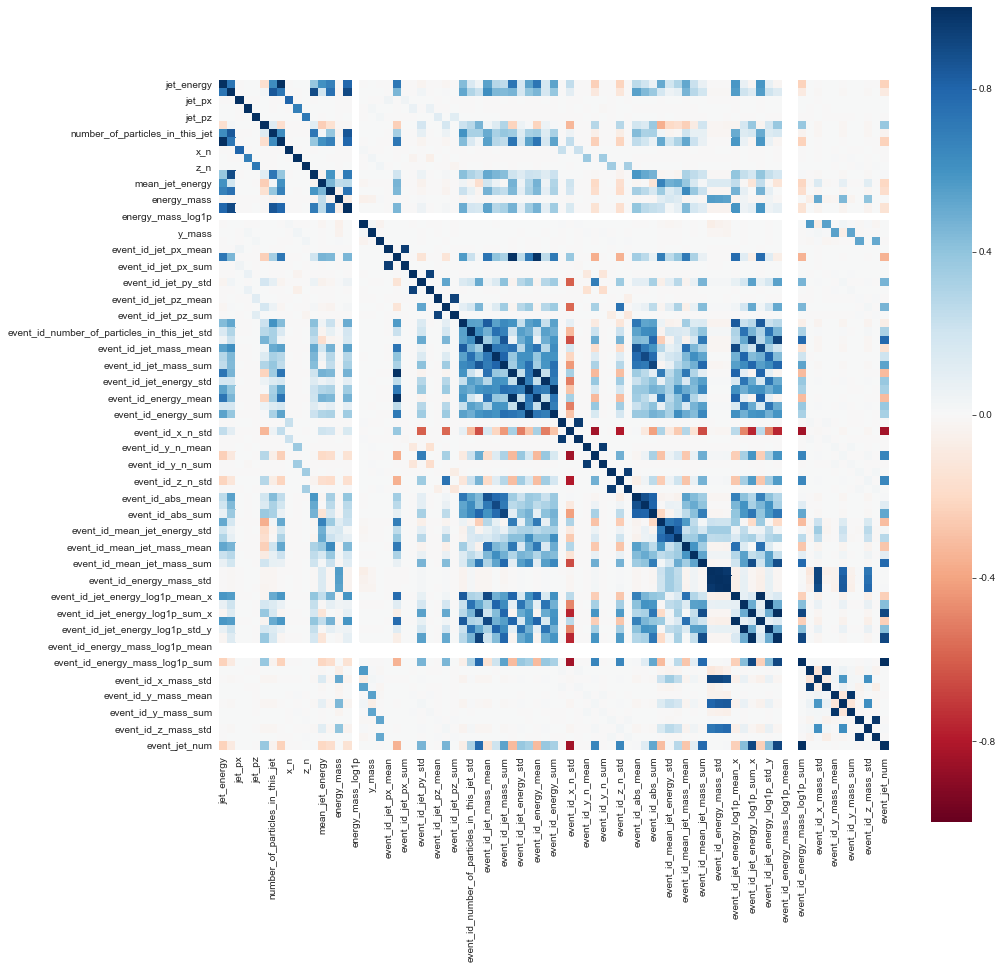

In [32]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(data_new.corr(), vmin=-1, vmax=1, center=0, 
            square=True, cmap='RdBu') #cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

# 模型训练

In [33]:
tr_index = ~data_new['label'].isnull()
train = data_new[tr_index].reset_index(drop=True)
y = data_new[tr_index]['label'].reset_index(drop=True).astype(int)
test = data_new[~tr_index].reset_index(drop=True)
print(train.shape,test.shape)



(1134555, 83) (537949, 83)


In [34]:
# from sklearn.preprocessing import LabelEncoder
# object_col = ['label']
# for i in tqdm(object_col):
#     lbl = LabelEncoder()
#     train[i] = lbl.fit_transform(train[i].astype(str))

d={1:0,4:1,5:2,21:3}
def label_process(x):
    x=d[x]
    return x
train['label']=train['label'].apply(label_process)

In [35]:
train.head()

,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet,energy,x_n,y_n,z_n,abs,mean_jet_energy,mean_jet_mass,energy_mass,jet_energy_log1p,energy_mass_log1p,x_mass,y_mass,z_mass,event_id_jet_px_mean,event_id_jet_px_std,event_id_jet_px_sum,event_id_jet_py_mean,event_id_jet_py_std,event_id_jet_py_sum,event_id_jet_pz_mean,event_id_jet_pz_std,event_id_jet_pz_sum,event_id_number_of_particles_in_this_jet_mean,event_id_number_of_particles_in_this_jet_std,event_id_number_of_particles_in_this_jet_sum,event_id_jet_mass_mean,event_id_jet_mass_std,event_id_jet_mass_sum,event_id_jet_energy_mean,event_id_jet_energy_std,event_id_jet_energy_sum,event_id_energy_mean,event_id_energy_std,event_id_energy_sum,event_id_x_n_mean,event_id_x_n_std,event_id_x_n_sum,event_id_y_n_mean,event_id_y_n_std,event_id_y_n_sum,event_id_z_n_mean,event_id_z_n_std,event_id_z_n_sum,event_id_abs_mean,event_id_abs_std,event_id_abs_sum,event_id_mean_jet_energy_mean,event_id_mean_jet_energy_std,event_id_mean_jet_energy_sum,event_id_mean_jet_mass_mean,event_id_mean_jet_mass_std,event_id_mean_jet_mass_sum,event_id_energy_mass_mean,event_id_energy_mass_std,event_id_energy_mass_sum,event_id_jet_energy_log1p_mean_x,event_id_jet_energy_log1p_std_x,event_id_jet_energy_log1p_sum_x,event_id_jet_energy_log1p_mean_y,event_id_jet_energy_log1p_std_y,event_id_jet_energy_log1p_sum_y,event_id_energy_mass_log1p_mean,event_id_energy_mass_log1p_std,event_id_energy_mass_log1p_sum,event_id_x_mass_mean,event_id_x_mass_std,event_id_x_mass_sum,event_id_y_mass_mean,event_id_y_mass_std,event_id_y_mass_sum,event_id_z_mass_mean,event_id_z_mass_std,event_id_z_mass_sum,event_jet_num
0,410e86bc0457482d9d6f81cd2d95ccf0,289.0660,17a0a1f19a7f43558cb9cca517b6e198,17.78110,-288.5120,0.30256,1.839620,0,21,288.518024,-0.999979,0.001049,0.006376,0.547976,13.765048,0.846719,16.256924,2.932851,1.0,-16.225768,0.017016,0.103459,4.628500,414.563271,9.2570,0.372525,0.098945,0.745050,-3.133425,7.032948,-6.266850,19.500000,2.121320,39,15.381200,3.393971,30.76240,293.614000,6.431843,587.2280,293.198839,6.619672,586.397677,-0.000175,1.413936,-0.000351,0.001267,0.000309,0.002534,-0.010419,0.023752,-0.020838,0.415161,0.187829,0.830323,15.164802,1.979551,30.329603,0.783951,0.088767,1.567902,19.612751,4.745856,39.225502,2.785286,0.208689,5.570572,2.785286,0.208689,5.570572,1.0,0.0,2.0,3.356268,27.693180,6.712536,0.025551,0.012071,0.051103,-0.260507,0.514726,-0.521014,2
1,6f7bf9104f8c4a619eedd129d5ce3dcb,159.7180,36d1005f56d343d5a09513cb7a4ead61,11.58480,-158.4480,2.13265,-16.283400,2,26,159.296786,-0.994672,0.013388,-0.102221,0.421214,6.143000,0.445569,13.786859,2.532490,1.0,-13.677232,0.184090,-1.405583,-5.328500,216.543674,-10.6570,-3.406570,7.833640,-6.813140,-4.259505,17.004355,-8.519010,30.000000,5.656854,60,13.487200,2.690400,26.97440,154.390000,7.534930,308.7800,153.780863,7.800693,307.561726,0.001066,1.408186,0.002132,-0.023474,0.052131,-0.046949,-0.024926,0.109311,-0.049852,0.609137,0.265763,1.218274,5.263588,1.243676,10.527176,0.449102,0.004996,0.898205,11.736375,2.899821,23.472750,2.664568,0.186787,5.329137,2.664568,0.186787,5.329137,1.0,0.0,2.0,-2.036964,16.461825,-4.073929,-0.198599,0.541204,-0.397198,-0.450531,1.350648,-0.901061,2
2,4ee694b125c944c1a4560a20b79ccbe3,113.3200,a82071a653304481979b5dfb8eb0da47,13.42170,-104.1430,-37.26720,-20.658500,1,27,112.522808,-0.925528,-0.331197,-0.183594,0.797192,4.197037,0.497100,8.443044,2.668734,1.0,-7.759300,-2.776638,-1.539187,-0.051775,125.640429,-0.2071,-0.985860,26.369892,-3.943440,0.112687,17.404047,0.450750,20.500000,5.916080,82,9.972905,5.437937,39.89162,98.016750,64.323257,392.0670,97.497389,64.115402,389.989556,-0.345535,0.923397,-1.382142,0.128148,0.407599,0.512590,0.093605,0.348947,0.374419,0.519361,0.259773,2.077444,4.496670,2.191263,17.986680,0.460754,0.156773,1.843018,9.465790,1.465046,37.863161,2.289364,0.549358,9.157458,2.289364,0.549358,9.157458,1.0,0.0,4.0,-2.308465,9.466229,-9.233859,1.130893,3.480975,4.523571,0

In [36]:
test.head()

,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet,energy,x_n,y_n,z_n,abs,mean_jet_energy,mean_jet_mass,energy_mass,jet_energy_log1p,energy_mass_log1p,x_mass,y_mass,z_mass,event_id_jet_px_mean,event_id_jet_px_std,event_id_jet_px_sum,event_id_jet_py_mean,event_id_jet_py_std,event_id_jet_py_sum,event_id_jet_pz_mean,event_id_jet_pz_std,event_id_jet_pz_sum,event_id_number_of_particles_in_this_jet_mean,event_id_number_of_particles_in_this_jet_std,event_id_number_of_particles_in_this_jet_sum,event_id_jet_mass_mean,event_id_jet_mass_std,event_id_jet_mass_sum,event_id_jet_energy_mean,event_id_jet_energy_std,event_id_jet_energy_sum,event_id_energy_mean,event_id_energy_std,event_id_energy_sum,event_id_x_n_mean,event_id_x_n_std,event_id_x_n_sum,event_id_y_n_mean,event_id_y_n_std,event_id_y_n_sum,event_id_z_n_mean,event_id_z_n_std,event_id_z_n_sum,event_id_abs_mean,event_id_abs_std,event_id_abs_sum,event_id_mean_jet_energy_mean,event_id_mean_jet_energy_std,event_id_mean_jet_energy_sum,event_id_mean_jet_mass_mean,event_id_mean_jet_mass_std,event_id_mean_jet_mass_sum,event_id_energy_mass_mean,event_id_energy_mass_std,event_id_energy_mass_sum,event_id_jet_energy_log1p_mean_x,event_id_jet_energy_log1p_std_x,event_id_jet_energy_log1p_sum_x,event_id_jet_energy_log1p_mean_y,event_id_jet_energy_log1p_std_y,event_id_jet_energy_log1p_sum_y,event_id_energy_mass_log1p_mean,event_id_energy_mass_log1p_std,event_id_energy_mass_log1p_sum,event_id_x_mass_mean,event_id_x_mass_std,event_id_x_mass_sum,event_id_y_mass_mean,event_id_y_mass_std,event_id_y_mass_sum,event_id_z_mass_mean,event_id_z_mass_std,event_id_z_mass_sum,event_jet_num
0,63d5670e5c514f00b64c0329382af524,87.5486,cb3b5c6ea5e441e9b425fc1e6a4a00e6,7.39969,-86.9773,0.268724,6.699850,NaN,23,87.235377,-0.997042,0.003080,0.076802,0.313223,3.806461,0.321726,11.831388,2.128195,1.0,-11.754182,0.036316,0.905423,-8.645550,110.777823,-17.2911,0.394493,0.177865,0.788987,2.872115,5.413234,5.744231,18.500000,6.363961,37,6.943580,0.645037,13.88716,78.772300,12.411562,157.5446,78.465035,12.403136,156.930070,0.001418,1.412035,0.002837,0.005273,0.003100,0.010545,0.031545,0.064003,0.063090,0.307265,0.008427,0.614530,4.403088,0.843758,8.806175,0.392558,0.100172,0.785116,11.310401,0.736787,22.620802,2.070713,0.081292,4.141426,2.070713,0.081292,4.141426,1.0,0.0,2.0,-0.506261,15.906962,-1.012521,0.058255,0.031027,0.116511,0.379060,0.744389,0.758121,2
1,8ddc9b4f189d42d08bde2936914341ed,73.2549,838bf5c3f9bc4a2194f51b3c57f403cd,11.06970,72.0487,-7.242040,-0.515331,NaN,26,72.413589,0.994961,-0.100009,-0.007116,0.841311,2.817496,0.425758,6.617605,2.490698,1.0,6.508641,-0.654222,-0.046553,0.935475,50.288083,3.7419,-1.560522,18.112839,-6.242090,-2.007980,18.097596,-8.031921,12.750000,9.287088,51,5.205082,4.319445,20.82033,43.124425,27.738854,172.4977,42.772867,27.475835,171.091467,-0.228182,0.821993,-0.912729,-0.218529,0.496112,-0.874117,0.152032,0.497613,0.608128,0.351558,0.350301,1.406233,3.497367,1.032787,13.989468,0.371828,0.145519,1.487310,11.431917,7.241554,45.727667,1.613824,0.793744,6.455297,1.613824,0.793744,6.455297,1.0,0.0,4.0,-4.610725,8.426859,-18.442899,-2.517903,6.212831,-10.071611,2.805153,8.273822,11.220614,4
2,e9a3a2a70f8f45999a0526c9b7538670,21.6806,fbc245d8b90b4a5d804880e097244a67,3.09542,21.4055,-0.877366,-1.224690,NaN,6,21.458450,0.997532,-0.040887,-0.057073,0.222150,3.613433,0.515903,7.004090,1.409869,1.0,6.915217,-0.283440,-0.395646,1.730833,51.325929,5.1925,2.475078,18.457668,7.425234,0.416537,18.584482,1.249610,11.000000,4.358899,33,5.536200,2.117056,16.60860,44.171333,21.404547,132.5140,43.815813,21.321919,131.447438,0.329457,1.052842,0.988370,0.001208,0.329857,0.003623,-0.041082,0.342596,-0.123245,0.355521,0.127363,1.066562,3.928608,0.575035,11.785824,0.505869,0.013117,1.517607,7.789004,1.354025,23.367011,1.835575,0.368984,5.506724,1.835575,0.368984,5.506724,1.0,0.0,3.0,1.588267,8.506482,4.764801,0.283888,2.732438,0.851665,-0.041657,2.757251,-0.124972,3

In [38]:
train.columns

Index(['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py',
       'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x_n',
       'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass',
       'jet_energy_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass',
       'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum',
       'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum',
       'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum',
       'event_id_number_of_particles_in_this_jet_mean',
       'event_id_number_of_particles_in_this_jet_std',
       'event_id_number_of_particles_in_this_jet_sum',
       'event_id_jet_mass_mean', 'event_id_jet_mass_std',
       'event_id_jet_mass_sum', 'event_id_jet_energy_mean',
       'event_id_jet_energy_std', 'event_id_jet_energy_sum',
       'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum',
       'event_id_x_n_mean', 'event_id

In [23]:
train_features =[ 'jet_energy', 'jet_mass', 'jet_px', 'jet_py',
       'jet_pz','number_of_particles_in_this_jet', 'energy', 'x_n',
       'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass',
       'jet_energy_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass',
       'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum',
       'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum',
       'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum',
       'event_id_number_of_particles_in_this_jet_mean',
       'event_id_number_of_particles_in_this_jet_std',
       'event_id_number_of_particles_in_this_jet_sum',
       'event_id_jet_mass_mean', 'event_id_jet_mass_std',
       'event_id_jet_mass_sum', 'event_id_jet_energy_mean',
       'event_id_jet_energy_std', 'event_id_jet_energy_sum',
       'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum',
       'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum',
       'event_id_y_n_mean', 'event_id_y_n_std', 'event_id_y_n_sum',
       'event_id_z_n_mean', 'event_id_z_n_std', 'event_id_z_n_sum',
       'event_id_abs_mean', 'event_id_abs_std', 'event_id_abs_sum',
       'event_id_mean_jet_energy_mean', 'event_id_mean_jet_energy_std',
       'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_mean',
       'event_id_mean_jet_mass_std', 'event_id_mean_jet_mass_sum',
       'event_id_energy_mass_mean', 'event_id_energy_mass_std',
       'event_id_energy_mass_sum', 'event_id_jet_energy_log1p_mean_x',
       'event_id_jet_energy_log1p_std_x', 'event_id_jet_energy_log1p_sum_x',
       'event_id_jet_energy_log1p_mean_y', 'event_id_jet_energy_log1p_std_y',
       'event_id_jet_energy_log1p_sum_y', 'event_id_energy_mass_log1p_mean',
       'event_id_energy_mass_log1p_std', 'event_id_energy_mass_log1p_sum',
       'event_id_x_mass_mean', 'event_id_x_mass_std', 'event_id_x_mass_sum',
       'event_id_y_mass_mean', 'event_id_y_mass_std', 'event_id_y_mass_sum',
       'event_id_z_mass_mean', 'event_id_z_mass_std', 'event_id_z_mass_sum',
       'event_jet_num']
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models = []

results = np.zeros((len(test), 4), dtype='float')

for index, (train_index, valid_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print("交叉验证: {} / {}".format( index+1, folds))
    X_train = train.iloc[train_index][train_features]
    X_valid = train.iloc[valid_index][train_features]
    Y_train =train['label'].iloc[train_index]
    Y_valid = train['label'].iloc[valid_index]
    
    model = CatBoostClassifier(
        iterations=4000 ,
        loss_function='MultiClass',
        eval_metric = 'Accuracy',
        verbose=200,
        learning_rate=0.05, 
        max_depth=6, 
        l2_leaf_reg=9, 
        early_stopping_rounds=50, 
        task_type="GPU",
        devices='0'
    )
    model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True)

    valid_pred = model.predict_proba(X_valid)
    results += model.predict_proba(test[train_features])
    
    valid_pred = valid_pred.argmax(axis=1)
    print('分类报告：\n',classification_report(Y_valid , valid_pred))
   
    
pred =results.argmax(axis=1)
d={1:0,4:1,5:2,21:3}

d={0:1,1:4,2:5,3:21}
out = [d[x] for x in pred]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1220-01.csv', index=False)






0it [00:00, ?it/s]

交叉验证: 1 / 5


0it [00:01, ?it/s]


KeyError: "['event_id_jet_energy_log1p_mean_x', 'event_id_jet_energy_log1p_std_y', 'event_id_jet_energy_log1p_std_x', 'event_id_jet_energy_log1p_mean_y', 'event_id_jet_energy_log1p_sum_x', 'event_id_jet_energy_log1p_sum_y'] not in index"

In [41]:
#  迭代2000论， 5折： 0.699219526478396， 提升明显
#  但看迭代还在一直提升

**catboost特征重要性**

[2.06939411e-03 3.12097465e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.61375349e-01 0.00000000e+00 2.97159126e-01
 0.00000000e+00 0.00000000e+00 2.74104070e-01 6.48879319e-02
 3.25121970e-01 1.38409979e-01 0.00000000e+00 1.32024153e-02
 2.11507051e-01 5.92943704e-02 0.00000000e+00 0.00000000e+00
 5.28276565e+00 2.45284719e-01 5.24480294e+00 4.86438203e-01
 8.34900345e-03 4.45247720e-01 1.19168634e+00 5.34416771e-03
 6.13525760e-01 7.04122136e+00 2.45705430e+00 1.28674356e+01
 1.52953325e-01 5.82997411e-02 1.09040424e-01 4.71607925e-02
 2.52438234e-01 9.18521750e-02 4.55114073e-02 3.70633293e-01
 3.81130590e-02 3.27451546e-01 3.08683864e-01 9.90091518e-02
 2.49375777e-02 6.88174418e-02 6.40916363e-02 7.60419102e-02
 5.45233705e-03 1.03621824e-01 6.49678937e-01 7.02654059e-01
 1.73834637e+00 5.76735187e+00 5.77362057e+00 6.32510428e-01
 3.93748786e+00 1.06883945e+00 8.17205681e-01 8.34567579e-01
 1.05487993e+00 2.05481144e-01 6.20624324e-02 5.34425987e-01
 1.13434581e-02 4.520998

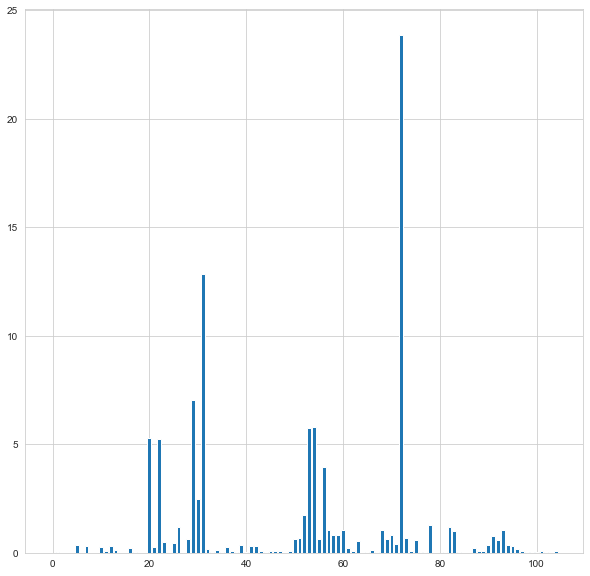

In [21]:
bold("**catboost特征重要性**")
print(model.feature_importances_)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
feature_important = dict(zip(train_features, model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print(feature_important)


feature_import_usefull = [key for (key, value) in feature_important if value > 0.0]

print("\n\n catboost 重要性 > 0.0 特征类别：", len(feature_import_usefull),  feature_import_usefull)



## 增加特征
```
x2 y2 z2 x/energy  y/energy/ z/energy
```


In [11]:
# del train, test
# gc.collect()

train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test= pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

# train = pd.read_csv('./jet_simple_data/simple_train_R04_jet_10000.csv')
# test= pd.read_csv('./jet_simple_data/simple_test_R04_jet_10000.csv')

data = train.append(test)
print('data shape: ', data.shape)

def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data['jet_mass']  = data['jet_mass'].map(lambda x : replace(x))
data['jet_energy']  = data['jet_energy'].map(lambda x : replace(x))
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)


# 根据坐标求方位
def count_column(df,column):
    tp = df.groupby(column).count().reset_index()
    tp = tp[list(tp.columns)[0:2]]
    tp.columns = [column, column+'_count']
    df=df.merge(tp,on=column,how='left')
    return df
def count_mean(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['mean']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_mean']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_count(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['count']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_count']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_sum(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['sum']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_sum']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_std(df,base_column,count_column):
#     tp = df.groupby(base_column)[[count_column]].std()
    tp = df.groupby(base_column).agg({count_column: ['std']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_std']
    df = df.merge(tp, on=base_column, how='left')
    return df

def get_mean_sum_std(df, base_column, count_column):
    df = count_mean(df, base_column, count_column)
    df = count_std(df, base_column, count_column)
    df = count_sum(df, base_column, count_column)
    
    return df

def energy(df):
    x=df['jet_px']
    y=df['jet_py']
    z= df['jet_pz']
    return (x**2+y**2+z**2)**0.5

def get_feature(data_):
    
    # 方向特征
    data = data_.copy()
    data['energy'] = data.apply(energy, axis =1)
    data['x_n']=data['jet_px']/data['energy']
    data['y_n']=data['jet_py']/data['energy']
    data['z_n']=data['jet_pz']/data['energy']
    
    data['abs'] = data['jet_energy'] - data['energy']
    data['mean_jet_energy'] = data['jet_energy'] /data['number_of_particles_in_this_jet']
    data['mean_jet_mass'] = data['jet_mass'] /data['number_of_particles_in_this_jet']
    data['energy_mass'] = data['jet_energy']/ data['jet_mass']
    
    data['jet_energy_log1p'] = np.log1p(data['jet_energy'])
    data['jet_mass_log1p'] = np.log1p(data['jet_mass'])
    data['energy_mass_log1p'] = data['jet_energy_log1p']/ data['jet_mass_log1p']
    
    data['x_mass'] = data['jet_px']/ data['jet_mass']
    data['y_mass'] = data['jet_py']/ data['jet_mass']
    data['z_mass'] = data['jet_pz']/ data['jet_mass']
    
    data = get_mean_sum_std(data, 'event_id', 'jet_px')
    data = get_mean_sum_std(data, 'event_id', 'jet_py')
    data = get_mean_sum_std(data, 'event_id', 'jet_pz')
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy')
    
    data = get_mean_sum_std(data, 'event_id', 'energy')
    data = get_mean_sum_std(data, 'event_id', 'x_n')
    data = get_mean_sum_std(data, 'event_id', 'y_n')
    data = get_mean_sum_std(data, 'event_id', 'z_n')
    data = get_mean_sum_std(data, 'event_id', 'abs')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_energy')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'x_mass')
    data = get_mean_sum_std(data, 'event_id', 'y_mass')
    data = get_mean_sum_std(data, 'event_id', 'z_mass')
    
     # event 统计特征
    evnet_jetnum_data = pd.DataFrame({"event_jet_num": data.groupby('event_id')['jet_id'].count()})
    data = data.merge(evnet_jetnum_data, on='event_id', how='left')
    
    ######  在上一版新增 1220-02
    data['x2'] = data['jet_px'].apply(lambda x : x**2)
    data['y2'] = data['jet_py'].apply(lambda x : x**2)
    data['z2'] = data['jet_pz'].apply(lambda x : x**2)
    data['x_energy'] = data['jet_px']/ data['jet_energy']
    data['y_energy'] = data['jet_py']/ data['jet_energy']
    data['z_energy'] = data['jet_pz']/ data['jet_energy']
    
    data = get_mean_sum_std(data, 'event_id', 'x2')
    data = get_mean_sum_std(data, 'event_id', 'y2')
    data = get_mean_sum_std(data, 'event_id', 'z2')
    data = get_mean_sum_std(data, 'event_id', 'x_energy')
    data = get_mean_sum_std(data, 'event_id', 'y_energy')
    data = get_mean_sum_std(data, 'event_id', 'z_energy')
    
    return data

data shape:  (1672504, 9)
(977, 9) (0, 9)
(0, 9) (0, 9)


In [12]:
data_new = get_feature(data)
tr_index = ~data_new['label'].isnull()
train = data_new[tr_index].reset_index(drop=True)
y = data_new[tr_index]['label'].reset_index(drop=True).astype(int)
test = data_new[~tr_index].reset_index(drop=True)
print(train.shape,test.shape)


d={1:0,4:1,5:2,21:3}
def label_process(x):
    x=d[x]
    return x
train['label']=train['label'].apply(label_process)

res = train.columns.tolist()

print(res)

(1134555, 108) (537949, 108)
['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x_n', 'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass', 'jet_energy_log1p', 'jet_mass_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 'event_id_jet_mass_std', 'event_id_jet_mass_sum', 'event_id_jet_energy_mean', 'event_id_jet_energy_std', 'event_id_jet_energy_sum', 'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum', 'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum', 'event_id_y_n_mean', 'even

In [24]:
train_features =['jet_energy', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'number_of_particles_in_this_jet', 'energy', 'x_n', 'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass', 'jet_energy_log1p', 'jet_mass_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 'event_id_jet_mass_std', 'event_id_jet_mass_sum', 'event_id_jet_energy_mean', 'event_id_jet_energy_std', 'event_id_jet_energy_sum', 'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum', 'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum', 'event_id_y_n_mean', 'event_id_y_n_std', 'event_id_y_n_sum', 'event_id_z_n_mean', 'event_id_z_n_std', 'event_id_z_n_sum', 'event_id_abs_mean', 'event_id_abs_std', 'event_id_abs_sum', 'event_id_mean_jet_energy_mean', 'event_id_mean_jet_energy_std', 'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_mean', 'event_id_mean_jet_mass_std', 'event_id_mean_jet_mass_sum', 'event_id_energy_mass_mean', 'event_id_energy_mass_std', 'event_id_energy_mass_sum', 'event_id_jet_energy_log1p_mean', 'event_id_jet_energy_log1p_std', 'event_id_jet_energy_log1p_sum', 'event_id_jet_mass_log1p_mean', 'event_id_jet_mass_log1p_std', 'event_id_jet_mass_log1p_sum', 'event_id_energy_mass_log1p_mean', 'event_id_energy_mass_log1p_std', 'event_id_energy_mass_log1p_sum', 'event_id_x_mass_mean', 'event_id_x_mass_std', 'event_id_x_mass_sum', 'event_id_y_mass_mean', 'event_id_y_mass_std', 'event_id_y_mass_sum', 'event_id_z_mass_mean', 'event_id_z_mass_std', 'event_id_z_mass_sum', 'event_jet_num', 'x2', 'y2', 'z2', 'x_energy', 'y_energy', 'z_energy', 'event_id_x2_mean', 'event_id_x2_std', 'event_id_x2_sum', 'event_id_y2_mean', 'event_id_y2_std', 'event_id_y2_sum', 'event_id_z2_mean', 'event_id_z2_std', 'event_id_z2_sum', 'event_id_x_energy_mean', 'event_id_x_energy_std', 'event_id_x_energy_sum', 'event_id_y_energy_mean', 'event_id_y_energy_std', 'event_id_y_energy_sum', 'event_id_z_energy_mean', 'event_id_z_energy_std', 'event_id_z_energy_sum']

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm 
    
folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

results = np.zeros((len(test), 4), dtype='float')

for index, (train_index, valid_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print("交叉验证: {} / {}".format( index+1, folds))
    X_train = train.iloc[train_index][train_features]
    X_valid = train.iloc[valid_index][train_features]
    Y_train =train['label'].iloc[train_index]
    Y_valid = train['label'].iloc[valid_index]
    
    model = CatBoostClassifier(
        iterations=4000 ,
        loss_function='MultiClass',
        eval_metric = 'Accuracy',
        verbose=200,
        learning_rate=0.05, 
        max_depth=4, 
        l2_leaf_reg=9, 
        early_stopping_rounds=50, 
        task_type="GPU",
        devices='0'
    )
    model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True)

    valid_pred = model.predict_proba(X_valid)
    results += model.predict_proba(test[train_features])
    
    valid_pred = valid_pred.argmax(axis=1)
    print('分类报告：\n',classification_report(Y_valid , valid_pred))
   
    
pred =results.argmax(axis=1)
d={1:0,4:1,5:2,21:3}

d={0:1,1:4,2:5,3:21}
out = [d[x] for x in pred]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1220-02.csv', index=False)
# 0.700021538198799
#0.699424301025903.





0it [00:00, ?it/s]

交叉验证: 1 / 5
0:	learn: 0.5011613	test: 0.5000110	best: 0.5000110 (0)	total: 31.2ms	remaining: 2m 4s
200:	learn: 0.5550041	test: 0.5545209	best: 0.5545517 (199)	total: 4.21s	remaining: 1m 19s
400:	learn: 0.5617501	test: 0.5606995	best: 0.5607435 (399)	total: 8.38s	remaining: 1m 15s
600:	learn: 0.5655104	test: 0.5637006	best: 0.5637094 (589)	total: 12.8s	remaining: 1m 12s
800:	learn: 0.5682956	test: 0.5660099	best: 0.5660848 (798)	total: 17.4s	remaining: 1m 9s
1000:	learn: 0.5706622	test: 0.5678035	best: 0.5678167 (997)	total: 22.1s	remaining: 1m 6s
1200:	learn: 0.5724845	test: 0.5692975	best: 0.5693371 (1193)	total: 26.7s	remaining: 1m 2s
1400:	learn: 0.5741416	test: 0.5706636	best: 0.5706725 (1397)	total: 31.4s	remaining: 58.2s
1600:	learn: 0.5757711	test: 0.5719769	best: 0.5720254 (1590)	total: 36s	remaining: 54s
1800:	learn: 0.5773080	test: 0.5729905	best: 0.5730522 (1794)	total: 40.7s	remaining: 49.6s
2000:	learn: 0.5787194	test: 0.5739953	best: 0.5740085 (1999)	total: 45.3s	remainin





1it [00:57, 57.12s/it]

交叉验证: 2 / 5
0:	learn: 0.5002683	test: 0.4999692	best: 0.4999692 (0)	total: 30.5ms	remaining: 2m 2s
200:	learn: 0.5543578	test: 0.5551579	best: 0.5552593 (199)	total: 4.88s	remaining: 1m 32s
400:	learn: 0.5612394	test: 0.5612837	best: 0.5612837 (400)	total: 9.53s	remaining: 1m 25s
600:	learn: 0.5651782	test: 0.5644920	best: 0.5645448 (595)	total: 14.1s	remaining: 1m 19s
800:	learn: 0.5679678	test: 0.5668673	best: 0.5668806 (799)	total: 18.7s	remaining: 1m 14s
1000:	learn: 0.5703156	test: 0.5687095	best: 0.5687095 (1000)	total: 23.4s	remaining: 1m 10s
1200:	learn: 0.5721468	test: 0.5702122	best: 0.5702166 (1197)	total: 28s	remaining: 1m 5s
1400:	learn: 0.5739944	test: 0.5712082	best: 0.5713184 (1393)	total: 32.7s	remaining: 1m
1600:	learn: 0.5756074	test: 0.5726713	best: 0.5726978 (1599)	total: 37.4s	remaining: 56s
1800:	learn: 0.5772732	test: 0.5740948	best: 0.5741389 (1798)	total: 42s	remaining: 51.3s
2000:	learn: 0.5787969	test: 0.5753552	best: 0.5753552 (1998)	total: 46.7s	remaining:





2it [02:37, 70.23s/it]

交叉验证: 3 / 5
0:	learn: 0.5001548	test: 0.5002865	best: 0.5002865 (0)	total: 30.8ms	remaining: 2m 3s
200:	learn: 0.5547037	test: 0.5536512	best: 0.5536512 (200)	total: 4.85s	remaining: 1m 31s
400:	learn: 0.5614365	test: 0.5602045	best: 0.5602045 (400)	total: 9.52s	remaining: 1m 25s
600:	learn: 0.5651450	test: 0.5642325	best: 0.5642325 (600)	total: 14.1s	remaining: 1m 19s
800:	learn: 0.5679522	test: 0.5666520	best: 0.5666916 (780)	total: 18.8s	remaining: 1m 14s
1000:	learn: 0.5701172	test: 0.5682694	best: 0.5682914 (992)	total: 23.4s	remaining: 1m 10s
1200:	learn: 0.5721158	test: 0.5699617	best: 0.5701159 (1183)	total: 28.1s	remaining: 1m 5s
1400:	learn: 0.5739325	test: 0.5714777	best: 0.5714909 (1394)	total: 32.8s	remaining: 1m
1600:	learn: 0.5755587	test: 0.5728174	best: 0.5728395 (1593)	total: 37.4s	remaining: 56.1s
1800:	learn: 0.5771034	test: 0.5742585	best: 0.5743202 (1787)	total: 42.1s	remaining: 51.4s
2000:	learn: 0.5786150	test: 0.5752325	best: 0.5752325 (2000)	total: 46.8s	remai





3it [04:06, 75.71s/it]

交叉验证: 4 / 5
0:	learn: 0.5004732	test: 0.4995152	best: 0.4995152 (0)	total: 30.2ms	remaining: 2m
200:	learn: 0.5544811	test: 0.5537261	best: 0.5537350 (198)	total: 4.91s	remaining: 1m 32s
400:	learn: 0.5610420	test: 0.5601296	best: 0.5601296 (400)	total: 9.65s	remaining: 1m 26s
600:	learn: 0.5650436	test: 0.5640078	best: 0.5640078 (600)	total: 14.2s	remaining: 1m 20s
800:	learn: 0.5678200	test: 0.5666652	best: 0.5666652 (800)	total: 18.2s	remaining: 1m 12s
1000:	learn: 0.5700841	test: 0.5683487	best: 0.5684633 (993)	total: 22.5s	remaining: 1m 7s
1200:	learn: 0.5720640	test: 0.5697589	best: 0.5697854 (1175)	total: 26.7s	remaining: 1m 2s
1400:	learn: 0.5738874	test: 0.5710943	best: 0.5711736 (1394)	total: 30.9s	remaining: 57.3s
1600:	learn: 0.5755433	test: 0.5724120	best: 0.5724384 (1586)	total: 35.1s	remaining: 52.5s
1800:	learn: 0.5771265	test: 0.5735314	best: 0.5736019 (1799)	total: 39.3s	remaining: 47.9s
2000:	learn: 0.5786106	test: 0.5744612	best: 0.5745009 (1967)	total: 43.3s	remain





4it [05:04, 70.36s/it]

交叉验证: 5 / 5
0:	learn: 0.4999543	test: 0.5011635	best: 0.5011635 (0)	total: 23.3ms	remaining: 1m 33s
200:	learn: 0.5547202	test: 0.5539068	best: 0.5539068 (200)	total: 4.13s	remaining: 1m 18s
400:	learn: 0.5616822	test: 0.5602441	best: 0.5602882 (397)	total: 8.19s	remaining: 1m 13s
600:	learn: 0.5652717	test: 0.5638976	best: 0.5638976 (600)	total: 12.2s	remaining: 1m 9s
800:	learn: 0.5680194	test: 0.5663699	best: 0.5663699 (800)	total: 16.2s	remaining: 1m 4s
1000:	learn: 0.5703838	test: 0.5682694	best: 0.5683399 (997)	total: 20.4s	remaining: 1m 1s
1200:	learn: 0.5725708	test: 0.5694504	best: 0.5694504 (1200)	total: 24.6s	remaining: 57.3s
1400:	learn: 0.5742631	test: 0.5708871	best: 0.5710105 (1396)	total: 28.8s	remaining: 53.3s
1600:	learn: 0.5758496	test: 0.5725838	best: 0.5725838 (1600)	total: 33s	remaining: 49.5s
1800:	learn: 0.5775198	test: 0.5736812	best: 0.5737385 (1796)	total: 37.6s	remaining: 45.9s
2000:	learn: 0.5788320	test: 0.5749504	best: 0.5750165 (1992)	total: 42.2s	remain





5it [06:13, 74.70s/it]


**catboost特征重要性**

[2.53029853e-03 5.65301360e-02 6.18892453e-03 0.00000000e+00
 4.95781867e-04 4.84331849e-01 3.22688407e-03 3.94647719e-01
 2.48147387e-03 4.37250578e-03 3.50504837e-01 1.21712708e-01
 3.46413919e-01 1.48412015e-01 4.97581421e-04 2.82857589e-02
 3.05606928e-01 1.45106097e-01 5.97495372e-03 1.66045172e-03
 4.90676270e+00 3.02710855e-01 4.99298510e+00 6.29345949e-01
 1.28869774e-01 5.76831104e-01 1.23357535e+00 8.34218890e-02
 7.13780336e-01 6.27178742e+00 2.33756042e+00 1.12129977e+01
 2.32098814e-01 2.03388241e-01 1.54024049e-01 9.27591750e-02
 3.11618516e-01 1.39420562e-01 7.53683220e-02 4.38154214e-01
 7.89324089e-02 4.12142291e-01 4.84152799e-01 2.27642545e-01
 8.19030616e-02 1.45703799e-01 1.53934383e-01 1.03998253e-01
 9.18143336e-02 1.41819411e-01 6.68054055e-01 7.65360898e-01
 1.62457342e+00 5.15399892e+00 5.38755090e+00 7.28106482e-01
 3.60838794e+00 1.19342552e+00 8.41004432e-01 8.43234289e-01
 1.21619487e+00 3.39124784e-01 1.41263331e-01 7.14025616e-01
 1.15066342e-01 1.141257

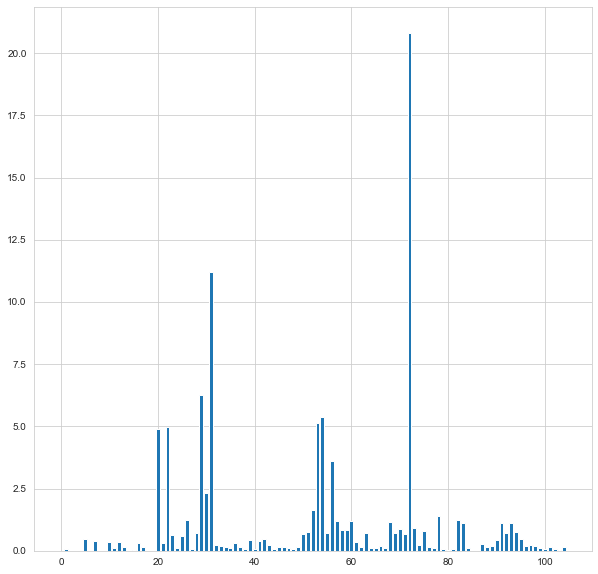

In [25]:
bold("**catboost特征重要性**")
print(model.feature_importances_)
plt.rcParams['figure.figsize'] = (10,10)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
feature_important = dict(zip(train_features, model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print(feature_important)


feature_import_usefull = [key for (key, value) in feature_important if value > 0.0]

print("\n\n catboost 重要性 > 0.0 特征类别：", len(feature_import_usefull),  feature_import_usefull)

## 特征工程2

In [2]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test= pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

# train = pd.read_csv('./jet_simple_data/simple_train_R04_jet_10000.csv')
# test= pd.read_csv('./jet_simple_data/simple_test_R04_jet_10000.csv')

data = train.append(test)
print('data shape: ', data.shape)

def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data['jet_mass']  = data['jet_mass'].map(lambda x : replace(x))
data['jet_energy']  = data['jet_energy'].map(lambda x : replace(x))
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)


# 根据坐标求方位
def count_column(df,column):
    tp = df.groupby(column).count().reset_index()
    tp = tp[list(tp.columns)[0:2]]
    tp.columns = [column, column+'_count']
    df=df.merge(tp,on=column,how='left')
    return df
def count_mean(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['mean']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_mean']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_count(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['count']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_count']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_sum(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['sum']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_sum']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_std(df,base_column,count_column):
#     tp = df.groupby(base_column)[[count_column]].std()
    tp = df.groupby(base_column).agg({count_column: ['std']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_std']
    df = df.merge(tp, on=base_column, how='left')
    return df

def get_mean_sum_std(df, base_column, count_column):
    df = count_mean(df, base_column, count_column)
    df = count_std(df, base_column, count_column)
    df = count_sum(df, base_column, count_column)
    
    return df

def energy(df):
    x=df['jet_px']
    y=df['jet_py']
    z= df['jet_pz']
    return (x**2+y**2+z**2)**0.5

def get_feature(data_):
    
    # 方向特征
    data = data_.copy()
    data['energy'] = data.apply(energy, axis =1)
    data['x_n']=data['jet_px']/data['energy']
    data['y_n']=data['jet_py']/data['energy']
    data['z_n']=data['jet_pz']/data['energy']
    
    data['abs'] = data['jet_energy'] - data['energy']
    data['mean_jet_energy'] = data['jet_energy'] /data['number_of_particles_in_this_jet']
    data['mean_jet_mass'] = data['jet_mass'] /data['number_of_particles_in_this_jet']
    data['energy_mass'] = data['jet_energy']/ data['jet_mass']
    
    data['jet_energy_log1p'] = np.log1p(data['jet_energy'])
    data['jet_mass_log1p'] = np.log1p(data['jet_mass'])
    data['energy_mass_log1p'] = data['jet_energy_log1p']/ data['jet_mass_log1p']
    
    data['x_mass'] = data['jet_px']/ data['jet_mass']
    data['y_mass'] = data['jet_py']/ data['jet_mass']
    data['z_mass'] = data['jet_pz']/ data['jet_mass']
    
    data = get_mean_sum_std(data, 'event_id', 'jet_px')
    data = get_mean_sum_std(data, 'event_id', 'jet_py')
    data = get_mean_sum_std(data, 'event_id', 'jet_pz')
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy')
    
    data = get_mean_sum_std(data, 'event_id', 'energy')
    data = get_mean_sum_std(data, 'event_id', 'x_n')
    data = get_mean_sum_std(data, 'event_id', 'y_n')
    data = get_mean_sum_std(data, 'event_id', 'z_n')
    data = get_mean_sum_std(data, 'event_id', 'abs')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_energy')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'x_mass')
    data = get_mean_sum_std(data, 'event_id', 'y_mass')
    data = get_mean_sum_std(data, 'event_id', 'z_mass')
    
     # event 统计特征
    evnet_jetnum_data = pd.DataFrame({"event_jet_num": data.groupby('event_id')['jet_id'].count()})
    data = data.merge(evnet_jetnum_data, on='event_id', how='left')
    
    ######  在上一版新增 1220-02
    data['x2'] = data['jet_px'].apply(lambda x : x**2)
    data['y2'] = data['jet_py'].apply(lambda x : x**2)
    data['z2'] = data['jet_pz'].apply(lambda x : x**2)
    data['x_energy'] = data['jet_px']/ data['jet_energy']
    data['y_energy'] = data['jet_py']/ data['jet_energy']
    data['z_energy'] = data['jet_pz']/ data['jet_energy']
    
    data = get_mean_sum_std(data, 'event_id', 'x2')
    data = get_mean_sum_std(data, 'event_id', 'y2')
    data = get_mean_sum_std(data, 'event_id', 'z2')
    data = get_mean_sum_std(data, 'event_id', 'x_energy')
    data = get_mean_sum_std(data, 'event_id', 'y_energy')
    data = get_mean_sum_std(data, 'event_id', 'z_energy')
    
     ######  在上一版新增 1220-03
    data['number_of_particles_in_this_jet_log1p'] = data['number_of_particles_in_this_jet'].apply(lambda x: np.log1p(x))
    
    return data

data shape:  (1672504, 9)
(977, 9) (0, 9)
(0, 9) (0, 9)


In [3]:
data_new = get_feature(data)
tr_index = ~data_new['label'].isnull()
train = data_new[tr_index].reset_index(drop=True)
y = data_new[tr_index]['label'].reset_index(drop=True).astype(int)
test = data_new[~tr_index].reset_index(drop=True)
print(train.shape,test.shape)


d={1:0,4:1,5:2,21:3}
def label_process(x):
    x=d[x]
    return x
train['label']=train['label'].apply(label_process)

res = train.columns.tolist()

print(res)

(1134555, 109) (537949, 109)
['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x_n', 'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass', 'jet_energy_log1p', 'jet_mass_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 'event_id_jet_mass_std', 'event_id_jet_mass_sum', 'event_id_jet_energy_mean', 'event_id_jet_energy_std', 'event_id_jet_energy_sum', 'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum', 'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum', 'event_id_y_n_mean', 'even

In [9]:
train_features =['jet_energy',  'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'number_of_particles_in_this_jet', 'energy', 'x_n', 'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass', 'jet_energy_log1p', 'jet_mass_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 'event_id_jet_mass_std', 'event_id_jet_mass_sum', 'event_id_jet_energy_mean', 'event_id_jet_energy_std', 'event_id_jet_energy_sum', 'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum', 'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum', 'event_id_y_n_mean', 'event_id_y_n_std', 'event_id_y_n_sum', 'event_id_z_n_mean', 'event_id_z_n_std', 'event_id_z_n_sum', 'event_id_abs_mean', 'event_id_abs_std', 'event_id_abs_sum', 'event_id_mean_jet_energy_mean', 'event_id_mean_jet_energy_std', 'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_mean', 'event_id_mean_jet_mass_std', 'event_id_mean_jet_mass_sum', 'event_id_energy_mass_mean', 'event_id_energy_mass_std', 'event_id_energy_mass_sum', 'event_id_jet_energy_log1p_mean', 'event_id_jet_energy_log1p_std', 'event_id_jet_energy_log1p_sum', 'event_id_jet_mass_log1p_mean', 'event_id_jet_mass_log1p_std', 'event_id_jet_mass_log1p_sum', 'event_id_energy_mass_log1p_mean', 'event_id_energy_mass_log1p_std', 'event_id_energy_mass_log1p_sum', 'event_id_x_mass_mean', 'event_id_x_mass_std', 'event_id_x_mass_sum', 'event_id_y_mass_mean', 'event_id_y_mass_std', 'event_id_y_mass_sum', 'event_id_z_mass_mean', 'event_id_z_mass_std', 'event_id_z_mass_sum', 'event_jet_num', 'x2', 'y2', 'z2', 'x_energy', 'y_energy', 'z_energy', 'event_id_x2_mean', 'event_id_x2_std', 'event_id_x2_sum', 'event_id_y2_mean', 'event_id_y2_std', 'event_id_y2_sum', 'event_id_z2_mean', 'event_id_z2_std', 'event_id_z2_sum', 'event_id_x_energy_mean', 'event_id_x_energy_std', 'event_id_x_energy_sum', 'event_id_y_energy_mean', 'event_id_y_energy_std', 'event_id_y_energy_sum', 'event_id_z_energy_mean', 'event_id_z_energy_std', 'event_id_z_energy_sum', 'number_of_particles_in_this_jet_log1p']

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

results = np.zeros((len(test), 4), dtype='float')

for index, (train_index, valid_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print("交叉验证: {} / {}".format( index+1, folds))
    X_train = train.iloc[train_index][train_features]
    X_valid = train.iloc[valid_index][train_features]
    Y_train =train['label'].iloc[train_index]
    Y_valid = train['label'].iloc[valid_index]
#     print("*" * 50)
#     print("lightgbm 训练")
#     params = {
#             'boosting_type': 'gbdt',
#             'objective': 'multiclass',
#             'num_class':4,
#             'metric': {'multi_logloss'},
#             'subsample': 0.25,
#             'subsample_freq': 1,
#             'learning_rate': 0.05,
#             'num_leaves': 20,
#             'feature_fraction': 0.9,
#             'lambda_l1': 3,  
#             'lambda_l2': 3
#             }
#     ## Lightgbm
#     lgb_model = lgb.train(params, 
#             train_set = lgb.Dataset(X_train, Y_train), 
#             valid_sets = [lgb.Dataset(X_train, Y_train), 
#                 lgb.Dataset(X_valid, Y_valid)],
#             num_boost_round=800, 
#             verbose_eval=50, 
#             early_stopping_rounds=50
#     )
#     lgb_pred= lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
#     lgb_pred = lgb_pred.argmax(axis=1)

#     print('lightgbm 分类报告：\n',classification_report(Y_valid , lgb_pred))
#     results += lgb_model.predict(test[train_features],  num_iteration=lgb_model.best_iteration)
    
    print("*" * 50)
    print("catboost 训练..")
    cat_model = CatBoostClassifier(
        iterations=1000 ,
        loss_function='MultiClass',
        eval_metric = 'Accuracy',
        verbose=200,
        learning_rate=0.05, 
        max_depth=8, 
        l2_leaf_reg=9, 
        early_stopping_rounds=50, 
        task_type="GPU",
        devices='0'
    )
    cat_model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True)

    cat_pred = cat_model.predict_proba(X_valid)
    cat_pred = cat_pred.argmax(axis=1)
    print('catboost 分类报告：\n',classification_report(Y_valid, cat_pred))

    results += cat_model.predict_proba(test[train_features])
    
    
          
pred =results.argmax(axis=1)
d={1:0,4:1,5:2,21:3}

d={0:1,1:4,2:5,3:21}
out = [d[x] for x in pred]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1221-01.csv', index=False)
# 增加特征：number_of_particles_in_this_jet_log1p，
# 训练时，在每一轮交叉验证中使用catboost和ligbhtgbm一起训练
# 0.700013710813086



0it [00:00, ?it/s]

交叉验证: 1 / 5
**************************************************
catboost 训练..
0:	learn: 0.5171345	test: 0.5160436	best: 0.5160436 (0)	total: 52.5ms	remaining: 52.5s
200:	learn: 0.5676787	test: 0.5646702	best: 0.5646702 (200)	total: 8.9s	remaining: 35.4s
400:	learn: 0.5799368	test: 0.5735326	best: 0.5735326 (400)	total: 17.5s	remaining: 26.2s
600:	learn: 0.5893194	test: 0.5804427	best: 0.5804427 (600)	total: 26.3s	remaining: 17.5s
800:	learn: 0.5983549	test: 0.5867271	best: 0.5867271 (800)	total: 34.9s	remaining: 8.67s
999:	learn: 0.6069838	test: 0.5929101	best: 0.5929101 (999)	total: 43.4s	remaining: 0us
bestTest = 0.592910058
bestIteration = 999
catboost 分类报告：
               precision    recall  f1-score   support

           0       0.53      0.66      0.59     52242
           1       0.48      0.23      0.31     52038
           2       0.59      0.52      0.55     50913
           3       0.68      0.86      0.76     71720

    accuracy                           0.59    226913
   m



1it [00:49, 49.59s/it]

交叉验证: 2 / 5
**************************************************
catboost 训练..
0:	learn: 0.5129528	test: 0.5141420	best: 0.5141420 (0)	total: 58ms	remaining: 57.9s
200:	learn: 0.5672891	test: 0.5658625	best: 0.5658714 (199)	total: 8.6s	remaining: 34.2s
400:	learn: 0.5788708	test: 0.5750599	best: 0.5750820 (398)	total: 16.8s	remaining: 25.1s
600:	learn: 0.5891534	test: 0.5816881	best: 0.5816881 (599)	total: 25.3s	remaining: 16.8s
800:	learn: 0.5983454	test: 0.5878755	best: 0.5879592 (799)	total: 33.7s	remaining: 8.36s
999:	learn: 0.6073864	test: 0.5943494	best: 0.5943670 (998)	total: 42s	remaining: 0us
bestTest = 0.5943669793
bestIteration = 998
Shrink model to first 999 iterations.
catboost 分类报告：
               precision    recall  f1-score   support

           0       0.53      0.66      0.59     52242
           1       0.48      0.24      0.32     52037
           2       0.59      0.52      0.55     50913
           3       0.68      0.86      0.76     71720

    accuracy           



2it [01:36, 48.93s/it]

交叉验证: 3 / 5
**************************************************
catboost 训练..
0:	learn: 0.5167461	test: 0.5154290	best: 0.5154290 (0)	total: 51.7ms	remaining: 51.6s
200:	learn: 0.5674950	test: 0.5651360	best: 0.5652065 (199)	total: 8.38s	remaining: 33.3s
400:	learn: 0.5791427	test: 0.5743026	best: 0.5743070 (399)	total: 16.7s	remaining: 24.9s
600:	learn: 0.5894661	test: 0.5818739	best: 0.5819135 (599)	total: 25.1s	remaining: 16.6s
800:	learn: 0.5985611	test: 0.5883214	best: 0.5883214 (800)	total: 33.3s	remaining: 8.27s
999:	learn: 0.6072308	test: 0.5939315	best: 0.5940020 (997)	total: 41.5s	remaining: 0us
bestTest = 0.5940020272
bestIteration = 997
Shrink model to first 998 iterations.
catboost 分类报告：
               precision    recall  f1-score   support

           0       0.53      0.67      0.59     52241
           1       0.49      0.23      0.32     52037
           2       0.59      0.52      0.55     50912
           3       0.67      0.85      0.75     71720

    accuracy      



3it [02:23, 48.31s/it]

交叉验证: 4 / 5
**************************************************
catboost 训练..
0:	learn: 0.5133769	test: 0.5124719	best: 0.5124719 (0)	total: 58.1ms	remaining: 58s
200:	learn: 0.5675380	test: 0.5647129	best: 0.5647129 (200)	total: 8.87s	remaining: 35.3s
400:	learn: 0.5792088	test: 0.5741263	best: 0.5741263 (400)	total: 17.5s	remaining: 26.2s
600:	learn: 0.5892160	test: 0.5816667	best: 0.5816667 (600)	total: 26s	remaining: 17.3s
800:	learn: 0.5981292	test: 0.5879600	best: 0.5879600 (800)	total: 34.8s	remaining: 8.64s
999:	learn: 0.6065786	test: 0.5940417	best: 0.5940417 (998)	total: 43.3s	remaining: 0us
bestTest = 0.5940416905
bestIteration = 998
Shrink model to first 999 iterations.
catboost 分类报告：
               precision    recall  f1-score   support

           0       0.53      0.66      0.59     52241
           1       0.48      0.23      0.32     52037
           2       0.59      0.52      0.55     50912
           3       0.68      0.85      0.75     71720

    accuracy          



4it [03:12, 48.41s/it]

交叉验证: 5 / 5
**************************************************
catboost 训练..
0:	learn: 0.5162624	test: 0.5173769	best: 0.5173769 (0)	total: 52.7ms	remaining: 52.7s
200:	learn: 0.5677429	test: 0.5650037	best: 0.5650037 (200)	total: 8.38s	remaining: 33.3s
400:	learn: 0.5793080	test: 0.5743070	best: 0.5743070 (400)	total: 16.5s	remaining: 24.6s
600:	learn: 0.5893626	test: 0.5815874	best: 0.5815874 (600)	total: 24.7s	remaining: 16.4s
800:	learn: 0.5983452	test: 0.5881054	best: 0.5881054 (800)	total: 32.9s	remaining: 8.18s
999:	learn: 0.6069058	test: 0.5936715	best: 0.5936715 (998)	total: 41.1s	remaining: 0us
bestTest = 0.5936714997
bestIteration = 998
Shrink model to first 999 iterations.
catboost 分类报告：
               precision    recall  f1-score   support

           0       0.53      0.66      0.59     52241
           1       0.48      0.24      0.32     52037
           2       0.59      0.52      0.55     50912
           3       0.67      0.85      0.75     71720

    accuracy      



5it [03:58, 47.79s/it]


**catboost特征重要性**

[2.18576317e-03 5.04594837e-02 5.13889903e-02 0.00000000e+00
 0.00000000e+00 3.75725145e-01 5.13163305e-03 3.73411183e-01
 1.48197727e-03 3.57024037e-03 2.09149109e-01 1.23118785e-01
 3.59519621e-01 1.28132718e-01 1.79677444e-02 6.11181076e-03
 3.61140771e-01 6.10285028e-02 5.59617218e-04 0.00000000e+00
 5.03487352e+00 4.61348822e-01 6.11334617e+00 9.14362434e-01
 2.11997825e-01 1.08116584e+00 1.53671201e+00 1.90028562e-01
 1.18587021e+00 5.11635036e+00 2.89536072e+00 7.48384101e+00
 3.27481584e-01 3.14382818e-01 1.85069670e-01 1.36863886e-01
 3.59919664e-01 2.43630704e-01 1.02902344e-01 6.27658009e-01
 2.34876088e-01 5.62216137e-01 5.72252961e-01 5.67835806e-01
 2.32046254e-01 2.59912983e-01 2.91620903e-01 1.61146746e-01
 1.92345372e-01 3.17395565e-01 1.18465936e+00 9.80479860e-01
 7.47246847e-01 2.54370500e+00 5.64988874e+00 1.33959483e+00
 3.68883560e+00 1.64970565e+00 1.21368744e+00 9.62315768e-01
 1.67340544e+00 3.82639475e-01 2.20764587e-01 1.08551501e+00
 3.08187270e-01 2.502414

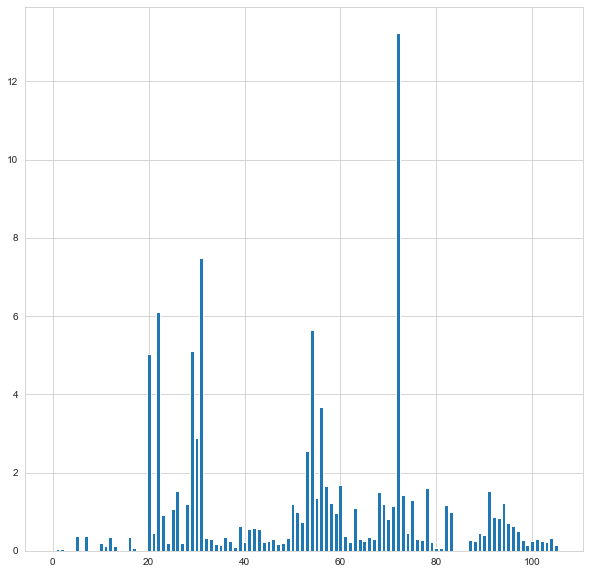

In [10]:
bold("**catboost特征重要性**")
print(cat_model.feature_importances_)
plt.rcParams['figure.figsize'] = (10,10)
print("feature num：", len(cat_model.feature_importances_))
plt.bar(range(len(cat_model.feature_importances_)), cat_model.feature_importances_)
feature_important = dict(zip(train_features, cat_model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("*" * 100)
print(feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value > 0.1]

print("*" * 100)
print("\n\n catboost 重要性 > 0.1 特征类别：", len(feature_import_usefull),  feature_import_usefull)

## 特征筛选
 上面的模型  过拟合较严重


In [20]:
train_features = ['event_id_x_mass_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_px_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_mean_jet_energy_std', 'event_id_jet_px_mean', 'event_id_mean_jet_mass_mean', 'event_id_mean_jet_energy_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_z_mass_std', 'event_id_energy_mass_std', 'event_id_abs_mean', 'event_id_y2_std', 'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_std', 'event_id_x_mass_sum', 'y2', 'event_id_energy_mass_mean', 'event_id_abs_sum', 'event_id_jet_pz_sum', 'event_id_z2_std', 'event_id_y_mass_std', 'z2', 'event_id_jet_pz_mean', 'event_id_abs_std', 'event_id_mean_jet_mass_sum', 'event_id_z2_mean', 'event_id_x_mass_mean', 'event_id_jet_py_sum', 'event_id_z2_sum', 'event_id_jet_py_mean', 'event_id_energy_std', 'abs', 'event_id_energy_mass_sum', 'event_id_jet_energy_std', 'event_id_y2_mean', 'event_id_y2_sum', 'event_id_x_n_std', 'event_id_x_energy_mean', 'event_id_y_mass_mean', 'event_id_x_n_mean', 'event_id_jet_px_std', 'event_id_x_energy_std', 'event_id_x2_sum', 'mean_jet_mass', 'event_id_x_n_sum', 'event_id_x2_mean', 'event_id_y_energy_sum', 'event_id_x_energy_sum', 'event_id_jet_mass_std', 'event_id_x2_std', 'number_of_particles_in_this_jet_log1p', 'event_id_y_mass_sum', 'event_id_jet_mass_mean', 'event_id_jet_energy_log1p_std_x', 'event_id_z_energy_sum', 'event_id_z_mass_mean', 'event_id_z_n_sum', 'event_id_y_n_sum', 'event_id_jet_energy_log1p_mean_x', 'x_n', 'event_id_y_n_std', 'event_id_jet_py_std', 'event_id_z_mass_sum', 'energy_mass', 'event_id_jet_energy_mean', 'event_id_jet_energy_log1p_sum_x', 'event_id_energy_sum', 'event_id_jet_mass_sum', 'number_of_particles_in_this_jet', 'event_id_y_energy_std', 'event_id_y_n_mean', 'event_id_jet_pz_std', 'event_id_y_energy_mean', 'event_id_jet_energy_sum', 'event_id_z_n_mean', 'event_id_z_energy_mean', 'event_id_energy_mean', 'event_id_z_energy_std', 'event_id_z_n_std', 'mean_jet_energy', 'x2', 'event_id_jet_energy_log1p_std_y']
# 选择上面特征权值>0.1 的83维特征
train_features = ['event_id_x_mass_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_mean_jet_energy_std', 'event_id_jet_px_sum', 'event_id_jet_px_mean', 'event_id_mean_jet_mass_mean', 'event_id_mean_jet_energy_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_z_mass_std', 'event_id_energy_mass_std', 'event_id_energy_mass_mean', 'event_id_y2_std', 'event_id_mean_jet_mass_std', 'event_id_abs_mean', 'event_id_x_mass_sum', 'event_id_mean_jet_energy_sum', 'y2', 'event_id_z2_mean', 'event_id_abs_sum', 'event_id_jet_pz_mean', 'event_id_abs_std', 'z2', 'event_id_jet_pz_sum', 'event_id_z2_std', 'event_id_y_mass_std', 'event_id_jet_py_mean', 'event_id_x_mass_mean', 'event_id_mean_jet_mass_sum', 'event_id_y2_sum', 'event_id_jet_py_sum', 'event_id_jet_energy_std', 'abs', 'event_id_energy_std', 'event_id_energy_mass_sum', 'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_y2_mean', 'event_id_z2_sum', 'event_id_y_mass_mean', 'number_of_particles_in_this_jet', 'event_id_x_energy_mean', 'event_id_jet_px_std', 'event_id_x2_sum', 'event_id_x_energy_std', 'event_id_jet_energy_log1p_sum_x', 'mean_jet_mass', 'event_id_x_energy_sum', 'event_id_x2_std', 'event_id_jet_energy_log1p_mean_x', 'event_id_jet_mass_std', 'event_id_x2_mean', 'event_id_jet_energy_log1p_std_x', 'event_id_y_energy_sum', 'event_id_x_n_sum', 'event_id_jet_py_std', 'event_id_z_energy_sum', 'event_id_jet_mass_mean', 'event_id_y_mass_sum', 'event_id_y_n_sum', 'event_id_z_mass_mean', 'x_n', 'event_id_z_n_sum', 'event_id_z_mass_sum', 'event_id_y_energy_std', 'event_id_y_n_std', 'event_id_energy_sum', 'mean_jet_energy', 'event_id_jet_mass_sum', 'event_id_z_n_mean', 'energy_mass']
# 选择上面特征权值>0.1 的83维特征
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

results = np.zeros((len(test), 4), dtype='float')

for index, (train_index, valid_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print("交叉验证: {} / {}".format( index+1, folds))
    X_train = train.iloc[train_index][train_features]
    X_valid = train.iloc[valid_index][train_features]
    Y_train =train['label'].iloc[train_index]
    Y_valid = train['label'].iloc[valid_index]
#     print("*" * 50)
#     print("lightgbm 训练")
#     params = {
#             'boosting_type': 'gbdt',
#             'objective': 'multiclass',
#             'num_class':4,
#             'metric': {'multi_logloss'},
#             'subsample': 0.25,
#             'subsample_freq': 1,
#             'learning_rate': 0.05,
#             'num_leaves': 20,
#             'feature_fraction': 0.9,
#             'lambda_l1': 3,  
#             'lambda_l2': 3
#             }
#     ## Lightgbm
#     lgb_model = lgb.train(params, 
#             train_set = lgb.Dataset(X_train, Y_train), 
#             valid_sets = [lgb.Dataset(X_train, Y_train), 
#                 lgb.Dataset(X_valid, Y_valid)],
#             num_boost_round=800, 
#             verbose_eval=50, 
#             early_stopping_rounds=50
#     )
#     lgb_pred= lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
#     lgb_pred = lgb_pred.argmax(axis=1)

#     print('lightgbm 分类报告：\n',classification_report(Y_valid , lgb_pred))
#     results += lgb_model.predict(test[train_features],  num_iteration=lgb_model.best_iteration)
    
    print("*" * 50)
    print("catboost 训练..")
    cat_model = CatBoostClassifier(
        iterations=4000 ,
        loss_function='MultiClass',
        eval_metric = 'Accuracy',
        verbose=200,
        learning_rate=0.05, 
        max_depth=4, 
        l2_leaf_reg=9, 
        early_stopping_rounds=50, 
        task_type="GPU",
        devices='0'
    )
    cat_model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True)

    cat_pred = cat_model.predict_proba(X_valid)
    cat_pred = cat_pred.argmax(axis=1)
    print('catboost 分类报告：\n',classification_report(Y_valid, cat_pred))

    results += cat_model.predict_proba(test[train_features])
    
    
          
pred =results.argmax(axis=1)
d={1:0,4:1,5:2,21:3}

d={0:1,1:4,2:5,3:21}
out = [d[x] for x in pred]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1221-02.csv', index=False)
#0.69998410759655


0it [00:00, ?it/s]

交叉验证: 1 / 5
**************************************************
catboost 训练..
0:	learn: 0.5074346	test: 0.5061808	best: 0.5061808 (0)	total: 36ms	remaining: 1m 12s
200:	learn: 0.5604389	test: 0.5594088	best: 0.5594088 (200)	total: 5.41s	remaining: 48.4s
400:	learn: 0.5679573	test: 0.5669888	best: 0.5669888 (400)	total: 10.6s	remaining: 42.2s
600:	learn: 0.5736941	test: 0.5714884	best: 0.5715325 (599)	total: 15.7s	remaining: 36.5s
800:	learn: 0.5781386	test: 0.5751154	best: 0.5751638 (797)	total: 20.8s	remaining: 31.2s
1000:	learn: 0.5821523	test: 0.5777904	best: 0.5777904 (1000)	total: 25.9s	remaining: 25.9s
1200:	learn: 0.5860348	test: 0.5802583	best: 0.5802716 (1196)	total: 31.1s	remaining: 20.7s
1400:	learn: 0.5896486	test: 0.5828673	best: 0.5828893 (1397)	total: 36.2s	remaining: 15.5s
1600:	learn: 0.5933218	test: 0.5853969	best: 0.5854057 (1599)	total: 41.4s	remaining: 10.3s
1800:	learn: 0.5967780	test: 0.5879838	best: 0.5879838 (1800)	total: 46.5s	remaining: 5.14s
1999:	learn: 0.59

1it [00:58, 58.34s/it]

交叉验证: 2 / 5
**************************************************
catboost 训练..
0:	learn: 0.5076054	test: 0.5083271	best: 0.5083271 (0)	total: 30.9ms	remaining: 1m 1s
200:	learn: 0.5613247	test: 0.5577914	best: 0.5577914 (200)	total: 5.42s	remaining: 48.5s
400:	learn: 0.5697256	test: 0.5643931	best: 0.5644372 (395)	total: 10.7s	remaining: 42.5s
600:	learn: 0.5749490	test: 0.5685886	best: 0.5685886 (600)	total: 15.9s	remaining: 37s
800:	learn: 0.5795631	test: 0.5721715	best: 0.5721715 (800)	total: 21.1s	remaining: 31.6s
1000:	learn: 0.5834821	test: 0.5751947	best: 0.5752299 (997)	total: 26.4s	remaining: 26.3s
1200:	learn: 0.5872743	test: 0.5781782	best: 0.5781914 (1199)	total: 32s	remaining: 21.3s
1400:	learn: 0.5910566	test: 0.5809458	best: 0.5809458 (1400)	total: 37.4s	remaining: 16s
1600:	learn: 0.5943090	test: 0.5830083	best: 0.5830083 (1600)	total: 43.1s	remaining: 10.7s
1800:	learn: 0.5976418	test: 0.5855732	best: 0.5855732 (1800)	total: 48.7s	remaining: 5.38s
1999:	learn: 0.6008942	

2it [01:58, 58.89s/it]

交叉验证: 3 / 5
**************************************************
catboost 训练..
0:	learn: 0.5074688	test: 0.5077806	best: 0.5077806 (0)	total: 33.2ms	remaining: 1m 6s
200:	learn: 0.5607187	test: 0.5609160	best: 0.5609160 (200)	total: 5.46s	remaining: 48.9s
400:	learn: 0.5683274	test: 0.5676499	best: 0.5676499 (400)	total: 10.8s	remaining: 43s
600:	learn: 0.5737712	test: 0.5717792	best: 0.5717792 (600)	total: 16.1s	remaining: 37.5s
800:	learn: 0.5785892	test: 0.5750713	best: 0.5751506 (797)	total: 21.5s	remaining: 32.2s
1000:	learn: 0.5827780	test: 0.5780416	best: 0.5780416 (1000)	total: 26.8s	remaining: 26.7s
1200:	learn: 0.5862640	test: 0.5804258	best: 0.5804743 (1188)	total: 32s	remaining: 21.3s
1400:	learn: 0.5900177	test: 0.5829466	best: 0.5830083 (1395)	total: 37.4s	remaining: 16s
1600:	learn: 0.5936215	test: 0.5853749	best: 0.5853749 (1600)	total: 42.8s	remaining: 10.7s
1800:	learn: 0.5969169	test: 0.5877459	best: 0.5878120 (1798)	total: 48s	remaining: 5.3s
1999:	learn: 0.6001847	te

3it [02:58, 59.12s/it]

交叉验证: 4 / 5
**************************************************
catboost 训练..
0:	learn: 0.5066865	test: 0.5076175	best: 0.5076175 (0)	total: 30.6ms	remaining: 1m 1s
200:	learn: 0.5604918	test: 0.5603959	best: 0.5604003 (199)	total: 5.53s	remaining: 49.5s
400:	learn: 0.5685941	test: 0.5673678	best: 0.5673678 (400)	total: 10.9s	remaining: 43.5s
600:	learn: 0.5742218	test: 0.5717704	best: 0.5717748 (599)	total: 16.2s	remaining: 37.8s
800:	learn: 0.5785793	test: 0.5755516	best: 0.5755516 (798)	total: 22s	remaining: 32.9s
1000:	learn: 0.5824178	test: 0.5788657	best: 0.5788834 (999)	total: 27.7s	remaining: 27.6s
1200:	learn: 0.5861120	test: 0.5816245	best: 0.5816245 (1197)	total: 33.3s	remaining: 22.2s
1400:	learn: 0.5896221	test: 0.5843216	best: 0.5843789 (1397)	total: 38.9s	remaining: 16.6s
1600:	learn: 0.5932734	test: 0.5867190	best: 0.5867190 (1600)	total: 44.5s	remaining: 11.1s
1800:	learn: 0.5966833	test: 0.5890327	best: 0.5891473 (1788)	total: 50s	remaining: 5.53s
1999:	learn: 0.600004

4it [04:00, 59.98s/it]

交叉验证: 5 / 5
**************************************************
catboost 训练..
0:	learn: 0.5076318	test: 0.5069168	best: 0.5069168 (0)	total: 31.2ms	remaining: 1m 2s
200:	learn: 0.5608135	test: 0.5594132	best: 0.5594132 (200)	total: 5.57s	remaining: 49.8s
400:	learn: 0.5688596	test: 0.5663498	best: 0.5664027 (399)	total: 11.2s	remaining: 44.6s
600:	learn: 0.5742086	test: 0.5710609	best: 0.5710609 (600)	total: 17s	remaining: 39.6s
800:	learn: 0.5784460	test: 0.5741458	best: 0.5741458 (800)	total: 22.6s	remaining: 33.9s
1000:	learn: 0.5825621	test: 0.5769487	best: 0.5770544 (996)	total: 28s	remaining: 28s
1200:	learn: 0.5862574	test: 0.5793285	best: 0.5793858 (1199)	total: 33.2s	remaining: 22.1s
1400:	learn: 0.5899560	test: 0.5822459	best: 0.5822944 (1390)	total: 38.3s	remaining: 16.4s
1600:	learn: 0.5936006	test: 0.5844714	best: 0.5844803 (1595)	total: 43.4s	remaining: 10.8s
1800:	learn: 0.5970590	test: 0.5871201	best: 0.5871289 (1797)	total: 48.6s	remaining: 5.37s
1999:	learn: 0.6000348	

5it [05:00, 60.00s/it]


**catboost特征重要性**

[15.2051203   8.71937766  5.63910015  6.09847564  5.83274669  5.04411852
  3.57821773  3.14703243  2.54351956  1.8071217   1.5896924   1.39534245
  1.44532799  1.36700095  1.44319962  1.39507396  1.30031075  1.57577949
  1.22648413  1.14451833  1.13096692  1.12016892  1.17934294  1.22220084
  1.21010127  0.8447097   1.22973067  0.89893178  0.79968563  0.52265453
  0.90033752  0.72154712  0.73925745  0.70754834  0.78791295  0.52423676
  0.81201597  0.55102752  0.43450209  0.48124578  0.65707081  0.41257662
  0.37385884  0.3764101   0.35919902  0.31926045  0.33967682  0.33716342
  0.35375407  0.33979189  0.34059472  0.15742142  0.29454982  0.30952776
  0.33942558  0.31326915  0.26912538  0.26283915  0.28846426  0.34047526
  0.26833882  0.22904386  0.31732056  0.25384916  0.20557037  0.10828416
  0.36032062  0.22856475  0.20837287  0.45173396  0.24251682  0.19973039
  0.18682798  0.16623076  0.1793898   0.20595192  0.14636872  0.15897579
  0.16202545  0.14838655  0.21240722  0.14510484  0

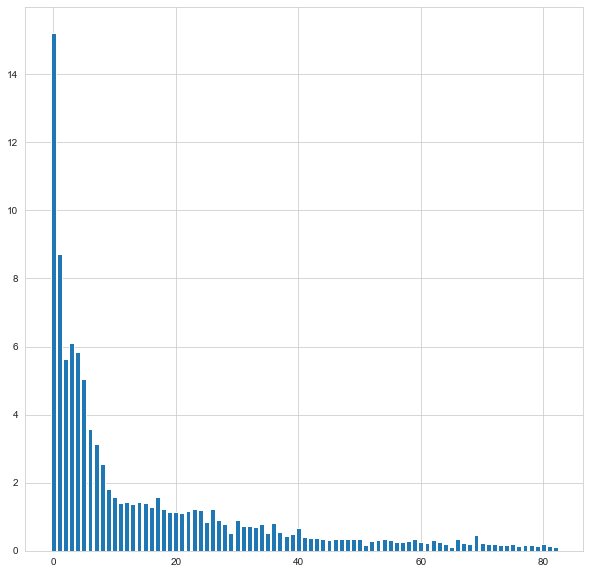

In [23]:
bold("**catboost特征重要性**")
print(cat_model.feature_importances_)
plt.rcParams['figure.figsize'] = (10,10)
print("feature num：", len(cat_model.feature_importances_))
plt.bar(range(len(cat_model.feature_importances_)), cat_model.feature_importances_)
feature_important = dict(zip(train_features, cat_model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("*" * 100)
print(feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value > 0.2]

print("*" * 100)
print("\n\n catboost 重要性 > 0.2 特征类别：", len(feature_import_usefull),  feature_import_usefull)

## 特征工程3


In [11]:
del train , test, data
gc.collect()

21139

In [12]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test= pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

# train = pd.read_csv('./jet_simple_data/simple_train_R04_jet_10000.csv')
# test= pd.read_csv('./jet_simple_data/simple_test_R04_jet_10000.csv')

data = train.append(test)
print('data shape: ', data.shape)

def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data['jet_mass']  = data['jet_mass'].map(lambda x : replace(x))
data['jet_energy']  = data['jet_energy'].map(lambda x : replace(x))
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

def count_column(df,column):
    tp = df.groupby(column).count().reset_index()
    tp = tp[list(tp.columns)[0:2]]
    tp.columns = [column, column+'_count']
    df=df.merge(tp,on=column,how='left')
    return df
def count_mean(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['mean']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_mean']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_count(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['count']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_count']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_sum(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['sum']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_sum']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_std(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['std']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_std']
    df = df.merge(tp, on=base_column, how='left')
    return df

def get_mean_sum_std(df, base_column, count_column):
    df = count_mean(df, base_column, count_column)
    df = count_std(df, base_column, count_column)
    df = count_sum(df, base_column, count_column)
    return df

def energy(df):
    x=df['jet_px']
    y=df['jet_py']
    z= df['jet_pz']
    return (x**2+y**2+z**2)**0.5

def get_feature(data_):
    # 方向特征
    data = data_.copy()
    data['energy'] = data.apply(energy, axis =1)
    data['x_n']=data['jet_px']/data['energy']
    data['y_n']=data['jet_py']/data['energy']
    data['z_n']=data['jet_pz']/data['energy']
    
    data['abs'] = data['jet_energy'] - data['energy']
    data['mean_jet_energy'] = data['jet_energy'] /data['number_of_particles_in_this_jet']
    data['mean_jet_mass'] = data['jet_mass'] /data['number_of_particles_in_this_jet']
    data['energy_mass'] = data['jet_energy']/ data['jet_mass']
    
    data['jet_energy_log1p'] = np.log1p(data['jet_energy'])
    data['jet_mass_log1p'] = np.log1p(data['jet_mass'])
    data['energy_mass_log1p'] = data['jet_energy_log1p']/ data['jet_mass_log1p']
    
    data['x_mass'] = data['jet_px']/ data['jet_mass']
    data['y_mass'] = data['jet_py']/ data['jet_mass']
    data['z_mass'] = data['jet_pz']/ data['jet_mass']
    
    data = get_mean_sum_std(data, 'event_id', 'jet_px')
    data = get_mean_sum_std(data, 'event_id', 'jet_py')
    data = get_mean_sum_std(data, 'event_id', 'jet_pz')
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy')
    
    data = get_mean_sum_std(data, 'event_id', 'energy')
    data = get_mean_sum_std(data, 'event_id', 'x_n')
    data = get_mean_sum_std(data, 'event_id', 'y_n')
    data = get_mean_sum_std(data, 'event_id', 'z_n')
    data = get_mean_sum_std(data, 'event_id', 'abs')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_energy')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'x_mass')
    data = get_mean_sum_std(data, 'event_id', 'y_mass')
    data = get_mean_sum_std(data, 'event_id', 'z_mass')
    
     # event 统计特征
    evnet_jetnum_data = pd.DataFrame({"event_jet_num": data.groupby('event_id')['jet_id'].count()})
    data = data.merge(evnet_jetnum_data, on='event_id', how='left')
    
    ######  在上一版新增 1220-02
    data['x2'] = data['jet_px'].apply(lambda x : x**2)
    data['y2'] = data['jet_py'].apply(lambda x : x**2)
    data['z2'] = data['jet_pz'].apply(lambda x : x**2)
    data['x_energy'] = data['jet_px']/ data['jet_energy']
    data['y_energy'] = data['jet_py']/ data['jet_energy']
    data['z_energy'] = data['jet_pz']/ data['jet_energy']
    
    data = get_mean_sum_std(data, 'event_id', 'x2')
    data = get_mean_sum_std(data, 'event_id', 'y2')
    data = get_mean_sum_std(data, 'event_id', 'z2')
    data = get_mean_sum_std(data, 'event_id', 'x_energy')
    data = get_mean_sum_std(data, 'event_id', 'y_energy')
    data = get_mean_sum_std(data, 'event_id', 'z_energy')
    
     ######  在上一版新增 1220-03
    data['number_of_particles_in_this_jet_log1p'] = data['number_of_particles_in_this_jet'].apply(lambda x: np.log1p(x))
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet_log1p')
    
    return data

data_new = get_feature(data)
tr_index = ~data_new['label'].isnull()
train = data_new[tr_index].reset_index(drop=True)
y = data_new[tr_index]['label'].reset_index(drop=True).astype(int)
test = data_new[~tr_index].reset_index(drop=True)
print(train.shape,test.shape)


d={1:0,4:1,5:2,21:3}
def label_process(x):
    x=d[x]
    return x
train['label']=train['label'].apply(label_process)

res = train.columns.tolist()

print(res)

data shape:  (1672504, 9)
(977, 9) (0, 9)
(0, 9) (0, 9)
(1134555, 112) (537949, 112)
['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x_n', 'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass', 'jet_energy_log1p', 'jet_mass_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 'event_id_jet_mass_std', 'event_id_jet_mass_sum', 'event_id_jet_energy_mean', 'event_id_jet_energy_std', 'event_id_jet_energy_sum', 'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum', 'event_id_x_n_mean', 'event_id_

In [17]:
train_features =['jet_energy','jet_mass', 'jet_px', 'jet_py', 'jet_pz','number_of_particles_in_this_jet', 'energy', 'x_n', 'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass', 'jet_energy_log1p', 'jet_mass_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 'event_id_jet_mass_std', 'event_id_jet_mass_sum', 'event_id_jet_energy_mean', 'event_id_jet_energy_std', 'event_id_jet_energy_sum', 'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum', 'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum', 'event_id_y_n_mean', 'event_id_y_n_std', 'event_id_y_n_sum', 'event_id_z_n_mean', 'event_id_z_n_std', 'event_id_z_n_sum', 'event_id_abs_mean', 'event_id_abs_std', 'event_id_abs_sum', 'event_id_mean_jet_energy_mean', 'event_id_mean_jet_energy_std', 'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_mean', 'event_id_mean_jet_mass_std', 'event_id_mean_jet_mass_sum', 'event_id_energy_mass_mean', 'event_id_energy_mass_std', 'event_id_energy_mass_sum', 'event_id_jet_energy_log1p_mean', 'event_id_jet_energy_log1p_std', 'event_id_jet_energy_log1p_sum', 'event_id_jet_mass_log1p_mean', 'event_id_jet_mass_log1p_std', 'event_id_jet_mass_log1p_sum', 'event_id_energy_mass_log1p_mean', 'event_id_energy_mass_log1p_std', 'event_id_energy_mass_log1p_sum', 'event_id_x_mass_mean', 'event_id_x_mass_std', 'event_id_x_mass_sum', 'event_id_y_mass_mean', 'event_id_y_mass_std', 'event_id_y_mass_sum', 'event_id_z_mass_mean', 'event_id_z_mass_std', 'event_id_z_mass_sum', 'event_jet_num', 'x2', 'y2', 'z2', 'x_energy', 'y_energy', 'z_energy', 'event_id_x2_mean', 'event_id_x2_std', 'event_id_x2_sum', 'event_id_y2_mean', 'event_id_y2_std', 'event_id_y2_sum', 'event_id_z2_mean', 'event_id_z2_std', 'event_id_z2_sum', 'event_id_x_energy_mean', 'event_id_x_energy_std', 'event_id_x_energy_sum', 'event_id_y_energy_mean', 'event_id_y_energy_std', 'event_id_y_energy_sum', 'event_id_z_energy_mean', 'event_id_z_energy_std', 'event_id_z_energy_sum', 'number_of_particles_in_this_jet_log1p', 'event_id_number_of_particles_in_this_jet_log1p_mean', 'event_id_number_of_particles_in_this_jet_log1p_std', 'event_id_number_of_particles_in_this_jet_log1p_sum']

from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

results = np.zeros((len(test), 4), dtype='float')

for index, (train_index, valid_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print("交叉验证: {} / {}".format( index+1, folds))
    X_train = train.iloc[train_index][train_features]
    X_valid = train.iloc[valid_index][train_features]
    Y_train =train['label'].iloc[train_index]
    Y_valid = train['label'].iloc[valid_index]
#     print("*" * 50)
#     print("lightgbm 训练")
#     params = {
#             'boosting_type': 'gbdt',
#             'objective': 'multiclass',
#             'num_class':4,
#             'metric': {'multi_logloss'},
#             'subsample': 0.25,
#             'subsample_freq': 1,
#             'learning_rate': 0.05,
#             'num_leaves': 20,
#             'feature_fraction': 0.9,
#             'lambda_l1': 3,  
#             'lambda_l2': 3
#             }
#     ## Lightgbm
#     lgb_model = lgb.train(params, 
#             train_set = lgb.Dataset(X_train, Y_train), 
#             valid_sets = [lgb.Dataset(X_train, Y_train), 
#                 lgb.Dataset(X_valid, Y_valid)],
#             num_boost_round=800, 
#             verbose_eval=50, 
#             early_stopping_rounds=50
#     )
#     lgb_pred= lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
#     lgb_pred = lgb_pred.argmax(axis=1)

#     print('lightgbm 分类报告：\n',classification_report(Y_valid , lgb_pred))
#     results += lgb_model.predict(test[train_features],  num_iteration=lgb_model.best_iteration)
    
    print("*" * 50)
    print("catboost 训练..")
    cat_model = CatBoostClassifier(
        iterations=2000 ,
        loss_function='MultiClass',
        eval_metric = 'Accuracy',
        verbose=200,
        learning_rate=0.02, 
        max_depth=8, 
        l2_leaf_reg=9, 
        early_stopping_rounds=50, 
        task_type="GPU",
        devices='0'
    )
    cat_model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True)

    cat_pred = cat_model.predict_proba(X_valid)
    cat_pred = cat_pred.argmax(axis=1)
    print('catboost 分类报告：\n',classification_report(Y_valid, cat_pred))
 
    results += cat_model.predict_proba(test[train_features])
     
    
          
pred =results.argmax(axis=1)
d={1:0,4:1,5:2,21:3}

d={0:1,1:4,2:5,3:21}
out = [d[x] for x in pred]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1221-04.csv', index=False)





0it [00:00, ?it/s]

交叉验证: 1 / 5
**************************************************
catboost 训练..
0:	learn: 0.5171345	test: 0.5160436	best: 0.5160436 (0)	total: 56.2ms	remaining: 1m 52s
200:	learn: 0.5559428	test: 0.5538114	best: 0.5538114 (200)	total: 9.03s	remaining: 1m 20s
400:	learn: 0.5649783	test: 0.5623697	best: 0.5623697 (400)	total: 17.8s	remaining: 1m 11s
600:	learn: 0.5705036	test: 0.5671513	best: 0.5671513 (600)	total: 26.5s	remaining: 1m 1s
800:	learn: 0.5757611	test: 0.5708708	best: 0.5708708 (800)	total: 35.2s	remaining: 52.7s
1000:	learn: 0.5799776	test: 0.5742950	best: 0.5742950 (1000)	total: 43.5s	remaining: 43.4s
1200:	learn: 0.5841301	test: 0.5770890	best: 0.5770890 (1200)	total: 52.2s	remaining: 34.7s
1400:	learn: 0.5879995	test: 0.5797641	best: 0.5797905 (1399)	total: 1m 1s	remaining: 26.1s
1600:	learn: 0.5918842	test: 0.5828357	best: 0.5828445 (1599)	total: 1m 10s	remaining: 17.5s
1800:	learn: 0.5956545	test: 0.5850656	best: 0.5850877 (1799)	total: 1m 19s	remaining: 8.74s
1999:	learn




1it [01:35, 95.30s/it]

交叉验证: 2 / 5
**************************************************
catboost 训练..
0:	learn: 0.5129528	test: 0.5141420	best: 0.5141420 (0)	total: 50ms	remaining: 1m 40s
200:	learn: 0.5557879	test: 0.5560658	best: 0.5561231 (199)	total: 8.75s	remaining: 1m 18s
400:	learn: 0.5644774	test: 0.5641262	best: 0.5641306 (399)	total: 17.2s	remaining: 1m 8s
600:	learn: 0.5704919	test: 0.5681806	best: 0.5681806 (600)	total: 25.5s	remaining: 59.2s
800:	learn: 0.5751171	test: 0.5718913	best: 0.5718913 (800)	total: 33.9s	remaining: 50.8s
1000:	learn: 0.5798502	test: 0.5750776	best: 0.5750820 (998)	total: 42.6s	remaining: 42.5s
1200:	learn: 0.5838970	test: 0.5781536	best: 0.5781536 (1200)	total: 51.5s	remaining: 34.3s
1400:	learn: 0.5878578	test: 0.5810534	best: 0.5810711 (1397)	total: 1m	remaining: 25.9s
1600:	learn: 0.5918362	test: 0.5839004	best: 0.5839268 (1597)	total: 1m 9s	remaining: 17.3s
1800:	learn: 0.5953883	test: 0.5867076	best: 0.5867164 (1799)	total: 1m 18s	remaining: 8.67s
1999:	learn: 0.5992




2it [03:08, 94.78s/it]

交叉验证: 3 / 5
**************************************************
catboost 训练..
0:	learn: 0.5167461	test: 0.5154290	best: 0.5154290 (0)	total: 56ms	remaining: 1m 51s
200:	learn: 0.5555829	test: 0.5547486	best: 0.5547486 (200)	total: 9.26s	remaining: 1m 22s
400:	learn: 0.5648596	test: 0.5626151	best: 0.5626151 (400)	total: 18.1s	remaining: 1m 12s
600:	learn: 0.5704202	test: 0.5673747	best: 0.5674012 (596)	total: 26.9s	remaining: 1m 2s
800:	learn: 0.5750817	test: 0.5713146	best: 0.5713146 (800)	total: 35.6s	remaining: 53.3s
1000:	learn: 0.5794788	test: 0.5744039	best: 0.5744039 (1000)	total: 44.4s	remaining: 44.3s
1200:	learn: 0.5834980	test: 0.5774360	best: 0.5774360 (1200)	total: 53.3s	remaining: 35.5s
1400:	learn: 0.5874268	test: 0.5806002	best: 0.5806002 (1400)	total: 1m 2s	remaining: 26.6s
1600:	learn: 0.5914207	test: 0.5833987	best: 0.5834251 (1597)	total: 1m 11s	remaining: 17.7s
1800:	learn: 0.5952327	test: 0.5859548	best: 0.5859592 (1799)	total: 1m 20s	remaining: 8.85s
1999:	learn: 




3it [04:44, 94.95s/it]

交叉验证: 4 / 5
**************************************************
catboost 训练..
0:	learn: 0.5133769	test: 0.5124719	best: 0.5124719 (0)	total: 54.1ms	remaining: 1m 48s
200:	learn: 0.5556578	test: 0.5539818	best: 0.5539818 (200)	total: 8.62s	remaining: 1m 17s
400:	learn: 0.5648816	test: 0.5620951	best: 0.5620951 (400)	total: 17.2s	remaining: 1m 8s
600:	learn: 0.5703034	test: 0.5668283	best: 0.5668635 (599)	total: 25.4s	remaining: 59.2s
800:	learn: 0.5751268	test: 0.5712044	best: 0.5712044 (800)	total: 33.8s	remaining: 50.6s
1000:	learn: 0.5798214	test: 0.5745141	best: 0.5745141 (1000)	total: 42.1s	remaining: 42s
1200:	learn: 0.5837965	test: 0.5775858	best: 0.5775858 (1200)	total: 50.4s	remaining: 33.5s
1400:	learn: 0.5878389	test: 0.5805209	best: 0.5805341 (1397)	total: 58.8s	remaining: 25.1s
1600:	learn: 0.5915595	test: 0.5830594	best: 0.5830770 (1598)	total: 1m 7s	remaining: 16.8s
1800:	learn: 0.5955699	test: 0.5856904	best: 0.5856904 (1800)	total: 1m 16s	remaining: 8.43s
1999:	learn: 0.




4it [06:15, 93.84s/it]

交叉验证: 5 / 5
**************************************************
catboost 训练..
0:	learn: 0.5162624	test: 0.5173769	best: 0.5173769 (0)	total: 52.1ms	remaining: 1m 44s
200:	learn: 0.5558572	test: 0.5545723	best: 0.5545723 (200)	total: 8.93s	remaining: 1m 19s
400:	learn: 0.5650789	test: 0.5626416	best: 0.5626768 (399)	total: 17.7s	remaining: 1m 10s
600:	learn: 0.5707562	test: 0.5675466	best: 0.5675466 (600)	total: 25.9s	remaining: 1m
800:	learn: 0.5754948	test: 0.5712926	best: 0.5712926 (800)	total: 34.1s	remaining: 51.1s
1000:	learn: 0.5797476	test: 0.5750606	best: 0.5750606 (1000)	total: 42.4s	remaining: 42.4s
1200:	learn: 0.5840951	test: 0.5777357	best: 0.5777709 (1195)	total: 50.9s	remaining: 33.8s
1400:	learn: 0.5878289	test: 0.5803138	best: 0.5803138 (1400)	total: 59.2s	remaining: 25.3s
1600:	learn: 0.5915209	test: 0.5831387	best: 0.5831784 (1598)	total: 1m 7s	remaining: 16.8s
1800:	learn: 0.5953352	test: 0.5855317	best: 0.5855405 (1797)	total: 1m 16s	remaining: 8.4s
1999:	learn: 0.5




5it [07:46, 93.34s/it]


**catboost特征重要性**

[1.92319766e-03 2.30607703e-02 3.58001271e-02 0.00000000e+00
 0.00000000e+00 3.69769071e-01 1.92015922e-03 4.11006851e-01
 0.00000000e+00 0.00000000e+00 1.97284728e-01 1.37298013e-01
 3.14287428e-01 1.45061542e-01 2.03735191e-03 2.96501670e-02
 4.06976723e-01 8.23584152e-02 0.00000000e+00 0.00000000e+00
 5.11522276e+00 3.52097816e-01 6.41575735e+00 8.22590223e-01
 2.01674789e-01 1.02627119e+00 1.34568988e+00 1.72136810e-01
 1.25006842e+00 4.70601739e+00 2.44474745e+00 7.98158089e+00
 2.89810174e-01 2.99124622e-01 1.09461940e-01 7.97317110e-02
 4.90730407e-01 2.20035207e-01 8.40415881e-02 5.33371986e-01
 1.71116211e-01 5.56306436e-01 5.73958789e-01 3.83261106e-01
 1.78637568e-01 2.59861133e-01 2.96162100e-01 1.64688237e-01
 1.82316669e-01 2.95729677e-01 1.11946983e+00 1.04497926e+00
 8.96557278e-01 2.71351361e+00 5.88132981e+00 1.35681658e+00
 3.91550809e+00 1.55441579e+00 1.15010093e+00 8.59865477e-01
 1.68804133e+00 4.00216803e-01 1.85961046e-01 9.26808538e-01
 1.82903510e-01 9.585716

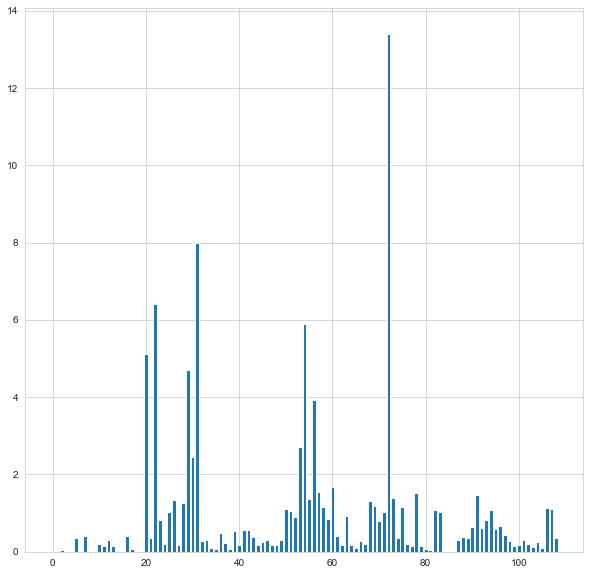

In [18]:
bold("**catboost特征重要性**")
print(cat_model.feature_importances_)
plt.rcParams['figure.figsize'] = (10,10)
print("feature num：", len(cat_model.feature_importances_))
plt.bar(range(len(cat_model.feature_importances_)), cat_model.feature_importances_)
feature_important = dict(zip(train_features, cat_model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("*" * 100)
print(feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value > 0.2]

print("*" * 100)
print("\n\n catboost 重要性 > 0.2 特征类别：", len(feature_import_usefull),  feature_import_usefull)

## 特征工程4


In [4]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test= pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

# train = pd.read_csv('./jet_simple_data/simple_train_R04_jet_10000.csv')
# test= pd.read_csv('./jet_simple_data/simple_test_R04_jet_10000.csv')

data = train.append(test)
print('data shape: ', data.shape)

def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data['jet_mass']  = data['jet_mass'].map(lambda x : replace(x))
data['jet_energy']  = data['jet_energy'].map(lambda x : replace(x))
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

def count_column(df,column):
    tp = df.groupby(column).count().reset_index()
    tp = tp[list(tp.columns)[0:2]]
    tp.columns = [column, column+'_count']
    df=df.merge(tp,on=column,how='left')
    return df
def count_mean(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['mean']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_mean']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_count(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['count']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_count']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_sum(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['sum']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_sum']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_std(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['std']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_std']
    df = df.merge(tp, on=base_column, how='left')
    return df

def get_mean_sum_std(df, base_column, count_column):
    print("hanlde column")
    df = count_mean(df, base_column, count_column)
    df = count_std(df, base_column, count_column)
    df = count_sum(df, base_column, count_column)
    return df

def energy(df):
    x=df['jet_px']
    y=df['jet_py']
    z= df['jet_pz']
    return (x**2+y**2+z**2)**0.5

def get_feature(data_):
    # 方向特征
    data = data_.copy()
    data['energy'] = data.apply(energy, axis =1)
    data['x_n']=data['jet_px']/data['energy']
    data['y_n']=data['jet_py']/data['energy']
    data['z_n']=data['jet_pz']/data['energy']
    
    data['abs'] = data['jet_energy'] - data['energy']
    data['mean_jet_energy'] = data['jet_energy'] /data['number_of_particles_in_this_jet']
    data['mean_jet_mass'] = data['jet_mass'] /data['number_of_particles_in_this_jet']
    data['energy_mass'] = data['jet_energy']/ data['jet_mass']
    
    data['jet_energy_log1p'] = np.log1p(data['jet_energy'])
    data['jet_mass_log1p'] = np.log1p(data['jet_mass'])
    data['energy_mass_log1p'] = data['jet_energy_log1p']/ data['jet_mass_log1p']
    
    data['x_mass'] = data['jet_px']/ data['jet_mass']
    data['y_mass'] = data['jet_py']/ data['jet_mass']
    data['z_mass'] = data['jet_pz']/ data['jet_mass']
    
    data = get_mean_sum_std(data, 'event_id', 'jet_px')
    data = get_mean_sum_std(data, 'event_id', 'jet_py')
    data = get_mean_sum_std(data, 'event_id', 'jet_pz')
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy')
    
    data = get_mean_sum_std(data, 'event_id', 'energy')
    data = get_mean_sum_std(data, 'event_id', 'x_n')
    data = get_mean_sum_std(data, 'event_id', 'y_n')
    data = get_mean_sum_std(data, 'event_id', 'z_n')
    data = get_mean_sum_std(data, 'event_id', 'abs')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_energy')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy_log1p')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass_log1p')
    data = get_mean_sum_std(data, 'event_id', 'x_mass')
    data = get_mean_sum_std(data, 'event_id', 'y_mass')
    data = get_mean_sum_std(data, 'event_id', 'z_mass')
    
     # event 统计特征
    evnet_jetnum_data = pd.DataFrame({"event_jet_num": data.groupby('event_id')['jet_id'].count()})
    data = data.merge(evnet_jetnum_data, on='event_id', how='left')
    
    ######  在上一版新增 1220-02
    data['x2'] = data['jet_px'].apply(lambda x : x**2)
    data['y2'] = data['jet_py'].apply(lambda x : x**2)
    data['z2'] = data['jet_pz'].apply(lambda x : x**2)
    data['x_energy'] = data['jet_px']/ data['jet_energy']
    data['y_energy'] = data['jet_py']/ data['jet_energy']
    data['z_energy'] = data['jet_pz']/ data['jet_energy']
    
    data = get_mean_sum_std(data, 'event_id', 'x2')
    data = get_mean_sum_std(data, 'event_id', 'y2')
    data = get_mean_sum_std(data, 'event_id', 'z2')
    data = get_mean_sum_std(data, 'event_id', 'x_energy')
    data = get_mean_sum_std(data, 'event_id', 'y_energy')
    data = get_mean_sum_std(data, 'event_id', 'z_energy')
    
     ######  在上一版新增 1220-03
    data['number_of_particles_in_this_jet_log1p'] = data['number_of_particles_in_this_jet'].apply(lambda x: np.log1p(x))
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet_log1p')
    
     ######  在上一版新增 1220-04
    
    data['x+y'] = data['jet_px']+data['jet_py']
    data['x+z'] = data['jet_px']+data['jet_pz']
    data['y+z'] = data['jet_py']+data['jet_pz']
    data['x-y'] = data['jet_px']-data['jet_py']
    data['x-z'] = data['jet_px']-data['jet_pz']
    data['y-z'] = data['jet_py']-data['jet_pz']
    data['x*y'] = data['jet_px']*data['jet_py']
    data['x*z'] = data['jet_px']*data['jet_pz']
    data['y*z'] = data['jet_py']*data['jet_pz']
    data['x/y'] = data['jet_px']/data['jet_py']
    data['x/z'] = data['jet_px']/data['jet_pz']
    data['y/z'] = data['jet_py']/data['jet_pz']
    data = get_mean_sum_std(data, 'event_id', 'x+y')
    data = get_mean_sum_std(data, 'event_id', 'x+z')
    data = get_mean_sum_std(data, 'event_id', 'y+z')
    data = get_mean_sum_std(data, 'event_id', 'x-y')
    data = get_mean_sum_std(data, 'event_id', 'x-z')
    data = get_mean_sum_std(data, 'event_id', 'y-z')
    data = get_mean_sum_std(data, 'event_id', 'x*y')
    data = get_mean_sum_std(data, 'event_id', 'x*z')
    data = get_mean_sum_std(data, 'event_id', 'y*z')
    data = get_mean_sum_std(data, 'event_id', 'x/y')
    data = get_mean_sum_std(data, 'event_id', 'x/z')
    data = get_mean_sum_std(data, 'event_id', 'y/z')
    return data

data_new = get_feature(data)
tr_index = ~data_new['label'].isnull()
train = data_new[tr_index].reset_index(drop=True)
y = data_new[tr_index]['label'].reset_index(drop=True).astype(int)
test = data_new[~tr_index].reset_index(drop=True)
print(train.shape,test.shape)


d={1:0,4:1,5:2,21:3}
def label_process(x):
    x=d[x]
    return x
train['label']=train['label'].apply(label_process)

res = train.columns.tolist()

print(res)

data shape:  (1672504, 9)
(977, 9) (0, 9)
(0, 9) (0, 9)
(1134555, 160) (537949, 160)
['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x_n', 'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass', 'jet_energy_log1p', 'jet_mass_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 'event_id_jet_mass_std', 'event_id_jet_mass_sum', 'event_id_jet_energy_mean', 'event_id_jet_energy_std', 'event_id_jet_energy_sum', 'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum', 'event_id_x_n_mean', 'event_id_

In [5]:
train_features =['jet_energy', 'jet_mass', 'jet_px', 'jet_py', 'jet_pz', 'number_of_particles_in_this_jet', 'energy', 'x_n', 'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass', 'jet_energy_log1p', 'jet_mass_log1p', 'energy_mass_log1p', 'x_mass', 'y_mass', 'z_mass', 'event_id_jet_px_mean', 'event_id_jet_px_std', 'event_id_jet_px_sum', 'event_id_jet_py_mean', 'event_id_jet_py_std', 'event_id_jet_py_sum', 'event_id_jet_pz_mean', 'event_id_jet_pz_std', 'event_id_jet_pz_sum', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_number_of_particles_in_this_jet_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_jet_mass_mean', 'event_id_jet_mass_std', 'event_id_jet_mass_sum', 'event_id_jet_energy_mean', 'event_id_jet_energy_std', 'event_id_jet_energy_sum', 'event_id_energy_mean', 'event_id_energy_std', 'event_id_energy_sum', 'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum', 'event_id_y_n_mean', 'event_id_y_n_std', 'event_id_y_n_sum', 'event_id_z_n_mean', 'event_id_z_n_std', 'event_id_z_n_sum', 'event_id_abs_mean', 'event_id_abs_std', 'event_id_abs_sum', 'event_id_mean_jet_energy_mean', 'event_id_mean_jet_energy_std', 'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_mean', 'event_id_mean_jet_mass_std', 'event_id_mean_jet_mass_sum', 'event_id_energy_mass_mean', 'event_id_energy_mass_std', 'event_id_energy_mass_sum', 'event_id_jet_energy_log1p_mean', 'event_id_jet_energy_log1p_std', 'event_id_jet_energy_log1p_sum', 'event_id_jet_mass_log1p_mean', 'event_id_jet_mass_log1p_std', 'event_id_jet_mass_log1p_sum', 'event_id_energy_mass_log1p_mean', 'event_id_energy_mass_log1p_std', 'event_id_energy_mass_log1p_sum', 'event_id_x_mass_mean', 'event_id_x_mass_std', 'event_id_x_mass_sum', 'event_id_y_mass_mean', 'event_id_y_mass_std', 'event_id_y_mass_sum', 'event_id_z_mass_mean', 'event_id_z_mass_std', 'event_id_z_mass_sum', 'event_jet_num', 'x2', 'y2', 'z2', 'x_energy', 'y_energy', 'z_energy', 'event_id_x2_mean', 'event_id_x2_std', 'event_id_x2_sum', 'event_id_y2_mean', 'event_id_y2_std', 'event_id_y2_sum', 'event_id_z2_mean', 'event_id_z2_std', 'event_id_z2_sum', 'event_id_x_energy_mean', 'event_id_x_energy_std', 'event_id_x_energy_sum', 'event_id_y_energy_mean', 'event_id_y_energy_std', 'event_id_y_energy_sum', 'event_id_z_energy_mean', 'event_id_z_energy_std', 'event_id_z_energy_sum', 'number_of_particles_in_this_jet_log1p', 'event_id_number_of_particles_in_this_jet_log1p_mean', 'event_id_number_of_particles_in_this_jet_log1p_std', 'event_id_number_of_particles_in_this_jet_log1p_sum', 'x+y', 'x+z', 'y+z', 'x-y', 'x-z', 'y-z', 'x*y', 'x*z', 'y*z', 'x/y', 'x/z', 'y/z', 'event_id_x+y_mean', 'event_id_x+y_std', 'event_id_x+y_sum', 'event_id_x+z_mean', 'event_id_x+z_std', 'event_id_x+z_sum', 'event_id_y+z_mean', 'event_id_y+z_std', 'event_id_y+z_sum', 'event_id_x-y_mean', 'event_id_x-y_std', 'event_id_x-y_sum', 'event_id_x-z_mean', 'event_id_x-z_std', 'event_id_x-z_sum', 'event_id_y-z_mean', 'event_id_y-z_std', 'event_id_y-z_sum', 'event_id_x*y_mean', 'event_id_x*y_std', 'event_id_x*y_sum', 'event_id_x*z_mean', 'event_id_x*z_std', 'event_id_x*z_sum', 'event_id_y*z_mean', 'event_id_y*z_std', 'event_id_y*z_sum', 'event_id_x/y_mean', 'event_id_x/y_std', 'event_id_x/y_sum', 'event_id_x/z_mean', 'event_id_x/z_std', 'event_id_x/z_sum', 'event_id_y/z_mean', 'event_id_y/z_std', 'event_id_y/z_sum']
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

results = np.zeros((len(test), 4), dtype='float')

for index, (train_index, valid_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print("交叉验证: {} / {}".format( index+1, folds))
    X_train = train.iloc[train_index][train_features]
    X_valid = train.iloc[valid_index][train_features]
    Y_train =train['label'].iloc[train_index]
    Y_valid = train['label'].iloc[valid_index]
#     print("*" * 50)
#     print("lightgbm 训练")
#     params = {
#             'boosting_type': 'gbdt',
#             'objective': 'multiclass',
#             'num_class':4,
#             'metric': {'multi_logloss'},
#             'subsample': 0.25,
#             'subsample_freq': 1,
#             'learning_rate': 0.05,
#             'num_leaves': 20,
#             'feature_fraction': 0.9,
#             'lambda_l1': 3,  
#             'lambda_l2': 3
#             }
#     ## Lightgbm
#     lgb_model = lgb.train(params, 
#             train_set = lgb.Dataset(X_train, Y_train), 
#             valid_sets = [lgb.Dataset(X_train, Y_train), 
#                 lgb.Dataset(X_valid, Y_valid)],
#             num_boost_round=800, 
#             verbose_eval=50, 
#             early_stopping_rounds=50
#     )
#     lgb_pred= lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
#     lgb_pred = lgb_pred.argmax(axis=1)

#     print('lightgbm 分类报告：\n',classification_report(Y_valid , lgb_pred))
#     results += lgb_model.predict(test[train_features],  num_iteration=lgb_model.best_iteration)
    
    print("*" * 50)
    print("catboost 训练..")
    cat_model = CatBoostClassifier(
        iterations=2000 ,
        loss_function='MultiClass',
        eval_metric = 'Accuracy',
        verbose=200,
        learning_rate=0.02, 
        max_depth=8, 
        l2_leaf_reg=9, 
        early_stopping_rounds=50, 
        task_type="GPU",
        devices='0'
    )
    cat_model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True)

    cat_pred = cat_model.predict_proba(X_valid)
    cat_pred = cat_pred.argmax(axis=1)
    print('catboost 分类报告：\n',classification_report(Y_valid, cat_pred))
 
    results += cat_model.predict_proba(test[train_features])
     
    
          
pred =results.argmax(axis=1)
d={1:0,4:1,5:2,21:3}

d={0:1,1:4,2:5,3:21}
out = [d[x] for x in pred]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1221-05.csv', index=False)
#0.701001089400853

0it [00:00, ?it/s]

交叉验证: 1 / 5
**************************************************
catboost 训练..
0:	learn: 0.5171345	test: 0.5160436	best: 0.5160436 (0)	total: 85ms	remaining: 2m 49s
200:	learn: 0.5594331	test: 0.5577953	best: 0.5578217 (199)	total: 10.3s	remaining: 1m 32s
400:	learn: 0.5688487	test: 0.5662214	best: 0.5662567 (399)	total: 20.2s	remaining: 1m 20s
600:	learn: 0.5749161	test: 0.5708135	best: 0.5708267 (597)	total: 30.1s	remaining: 1m 10s
800:	learn: 0.5801726	test: 0.5750706	best: 0.5751676 (799)	total: 40s	remaining: 59.9s
1000:	learn: 0.5850060	test: 0.5784023	best: 0.5784067 (999)	total: 50.1s	remaining: 50s
1200:	learn: 0.5894879	test: 0.5816238	best: 0.5816238 (1199)	total: 1m	remaining: 39.9s
1400:	learn: 0.5938608	test: 0.5849775	best: 0.5849775 (1400)	total: 1m 10s	remaining: 29.9s
1600:	learn: 0.5983582	test: 0.5878288	best: 0.5878288 (1600)	total: 1m 20s	remaining: 19.9s
1800:	learn: 0.6025592	test: 0.5906449	best: 0.5906757 (1798)	total: 1m 30s	remaining: 9.96s
1999:	learn: 0.6065

1it [01:49, 109.40s/it]

交叉验证: 2 / 5
**************************************************
catboost 训练..
0:	learn: 0.5129528	test: 0.5141420	best: 0.5141420 (0)	total: 66.6ms	remaining: 2m 13s
200:	learn: 0.5592441	test: 0.5591286	best: 0.5591286 (200)	total: 10.5s	remaining: 1m 33s
400:	learn: 0.5682851	test: 0.5670480	best: 0.5670480 (400)	total: 20.5s	remaining: 1m 21s
600:	learn: 0.5742335	test: 0.5722306	best: 0.5722306 (598)	total: 30.5s	remaining: 1m 10s
800:	learn: 0.5793225	test: 0.5763159	best: 0.5763424 (799)	total: 40.4s	remaining: 1m
1000:	learn: 0.5844203	test: 0.5799781	best: 0.5799781 (1000)	total: 50.4s	remaining: 50.3s
1200:	learn: 0.5891006	test: 0.5834509	best: 0.5834509 (1200)	total: 1m	remaining: 40.2s
1400:	learn: 0.5936156	test: 0.5867693	best: 0.5867737 (1399)	total: 1m 10s	remaining: 30.2s
1600:	learn: 0.5980446	test: 0.5898454	best: 0.5898763 (1599)	total: 1m 20s	remaining: 20.1s
1800:	learn: 0.6023635	test: 0.5924367	best: 0.5924367 (1800)	total: 1m 30s	remaining: 10s
1999:	learn: 0.60

2it [03:37, 109.05s/it]

交叉验证: 3 / 5
**************************************************
catboost 训练..
0:	learn: 0.5167461	test: 0.5154290	best: 0.5154290 (0)	total: 67.4ms	remaining: 2m 14s
200:	learn: 0.5596803	test: 0.5584064	best: 0.5584064 (200)	total: 10.5s	remaining: 1m 34s
400:	learn: 0.5687246	test: 0.5662465	best: 0.5662465 (400)	total: 20.5s	remaining: 1m 21s
600:	learn: 0.5745605	test: 0.5712617	best: 0.5712750 (599)	total: 30.6s	remaining: 1m 11s
800:	learn: 0.5797685	test: 0.5752633	best: 0.5752633 (800)	total: 40.6s	remaining: 1m
1000:	learn: 0.5846691	test: 0.5788506	best: 0.5788506 (1000)	total: 50.6s	remaining: 50.5s
1200:	learn: 0.5892612	test: 0.5822308	best: 0.5822308 (1200)	total: 1m	remaining: 40.3s
1400:	learn: 0.5937145	test: 0.5857873	best: 0.5858005 (1399)	total: 1m 10s	remaining: 30.2s
1600:	learn: 0.5979056	test: 0.5888238	best: 0.5888238 (1599)	total: 1m 20s	remaining: 20.1s
1800:	learn: 0.6020382	test: 0.5916531	best: 0.5916575 (1798)	total: 1m 30s	remaining: 10s
1999:	learn: 0.60

3it [05:25, 108.84s/it]

交叉验证: 4 / 5
**************************************************
catboost 训练..
0:	learn: 0.5133769	test: 0.5124719	best: 0.5124719 (0)	total: 66ms	remaining: 2m 11s
200:	learn: 0.5594875	test: 0.5571416	best: 0.5571416 (200)	total: 10.4s	remaining: 1m 33s
400:	learn: 0.5689174	test: 0.5661011	best: 0.5661452 (399)	total: 20.4s	remaining: 1m 21s
600:	learn: 0.5745826	test: 0.5708651	best: 0.5708695 (599)	total: 30.3s	remaining: 1m 10s
800:	learn: 0.5795449	test: 0.5751091	best: 0.5751267 (796)	total: 40.2s	remaining: 1m
1000:	learn: 0.5845336	test: 0.5788462	best: 0.5788462 (1000)	total: 50.4s	remaining: 50.3s
1200:	learn: 0.5892127	test: 0.5822617	best: 0.5822617 (1200)	total: 1m	remaining: 40.2s
1400:	learn: 0.5937310	test: 0.5857741	best: 0.5858358 (1399)	total: 1m 10s	remaining: 30.1s
1600:	learn: 0.5980058	test: 0.5892733	best: 0.5892733 (1600)	total: 1m 20s	remaining: 20.1s
1800:	learn: 0.6022410	test: 0.5921511	best: 0.5921511 (1800)	total: 1m 30s	remaining: 10s
1999:	learn: 0.6064

4it [07:14, 108.64s/it]

交叉验证: 5 / 5
**************************************************
catboost 训练..
0:	learn: 0.5162624	test: 0.5173769	best: 0.5173769 (0)	total: 65.7ms	remaining: 2m 11s
200:	learn: 0.5592792	test: 0.5579613	best: 0.5579613 (200)	total: 10.5s	remaining: 1m 33s
400:	learn: 0.5688524	test: 0.5670089	best: 0.5670089 (400)	total: 20.5s	remaining: 1m 21s
600:	learn: 0.5746751	test: 0.5713455	best: 0.5713455 (600)	total: 30.6s	remaining: 1m 11s
800:	learn: 0.5798324	test: 0.5752765	best: 0.5752765 (800)	total: 40.5s	remaining: 1m
1000:	learn: 0.5843166	test: 0.5788815	best: 0.5789079 (995)	total: 50.5s	remaining: 50.4s
1200:	learn: 0.5886520	test: 0.5820546	best: 0.5820546 (1200)	total: 1m	remaining: 40.3s
1400:	learn: 0.5930435	test: 0.5855229	best: 0.5855229 (1399)	total: 1m 10s	remaining: 30.2s
1600:	learn: 0.5971024	test: 0.5884007	best: 0.5884404 (1590)	total: 1m 20s	remaining: 20.1s
1800:	learn: 0.6015931	test: 0.5918558	best: 0.5918690 (1798)	total: 1m 30s	remaining: 10s
1999:	learn: 0.605

5it [09:02, 108.48s/it]


**catboost特征重要性**

[4.69207557e-03 1.60550724e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.61803016e-01 8.79460796e-04 7.83923445e-02
 0.00000000e+00 0.00000000e+00 1.96920536e-01 7.20871541e-02
 1.97523622e-01 4.11170294e-02 1.98544146e-03 0.00000000e+00
 1.13818145e-01 1.55806022e-03 0.00000000e+00 0.00000000e+00
 3.81330099e+00 1.71668823e-01 4.88472252e+00 4.92765169e-01
 2.63947358e-01 3.40514709e-01 3.69551926e-01 9.28486773e-02
 3.32713973e-01 5.52956297e+00 2.57871485e+00 6.99601329e+00
 2.51699846e-01 3.30975607e-01 1.27658235e-01 4.43568612e-02
 4.83124838e-01 1.89722800e-01 2.73763548e-02 4.25309215e-01
 1.37425984e-01 3.36437045e-01 4.56096732e-01 3.02664314e-01
 1.44327253e-01 2.97381946e-01 2.49698203e-01 1.92188647e-01
 2.27855603e-01 2.76284815e-01 1.20961870e+00 9.16661547e-01
 8.15294516e-01 2.47614199e+00 5.67919583e+00 1.02724468e+00
 3.70081246e+00 1.51340855e+00 9.17029482e-01 9.16190729e-01
 1.96942783e+00 4.28383101e-01 1.24554121e-01 8.33994923e-01
 1.59346329e-01 1.079077

[('event_id_x_mass_std', 10.984405293850573), ('event_id_number_of_particles_in_this_jet_sum', 6.996013287142608), ('event_id_mean_jet_energy_std', 5.6791958348022), ('event_id_number_of_particles_in_this_jet_mean', 5.529562974015991), ('event_id_jet_px_sum', 4.884722523431776), ('event_id_x/z_std', 3.8292462421336424), ('event_id_jet_px_mean', 3.8133009867934073), ('event_id_mean_jet_mass_mean', 3.700812463959907), ('event_id_x/y_std', 3.485818046462971), ('event_id_number_of_particles_in_this_jet_std', 2.5787148450186415), ('event_id_mean_jet_energy_mean', 2.4761419927190342), ('event_id_energy_mass_std', 1.969427833600662), ('event_id_mean_jet_mass_std', 1.5134085504667818), ('event_id_energy_mass_log1p_mean', 1.2975730879625798), ('event_id_abs_mean', 1.209618700038167), ('event_id_energy_mass_log1p_std', 1.151969615512942), ('event_id_z_mass_std', 1.1336185328988357), ('event_id_x_mass_sum', 1.1142281295268595), ('event_id_number_of_particles_in_this_jet_log1p_std', 1.040832217874

 catboost 重要性 > 0.1 特征类别： 118 ['event_id_x_mass_std', 'event_id_number_of_particles_in_this_jet_sum', 'event_id_mean_jet_energy_std', 'event_id_number_of_particles_in_this_jet_mean', 'event_id_jet_px_sum', 'event_id_x/z_std', 'event_id_jet_px_mean', 'event_id_mean_jet_mass_mean', 'event_id_x/y_std', 'event_id_number_of_particles_in_this_jet_std', 'event_id_mean_jet_energy_mean', 'event_id_energy_mass_std', 'event_id_mean_jet_mass_std', 'event_id_energy_mass_log1p_mean', 'event_id_abs_mean', 'event_id_energy_mass_log1p_std', 'event_id_z_mass_std', 'event_id_x_mass_sum', 'event_id_number_of_particles_in_this_jet_log1p_std', 'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_sum', 'event_id_abs_std', 'event_id_energy_mass_mean', 'event_id_number_of_particles_in_this_jet_log1p_mean', 'event_id_x_mass_mean', 'event_id_y2_std', 'event_id_jet_energy_log1p_std', 'event_id_abs_sum', 'event_id_y_mass_std', 'event_id_y*z_std', 'event_id_y/z_std', 'event_id_x-z_sum', 'event_id_y+z_mean', 'eve

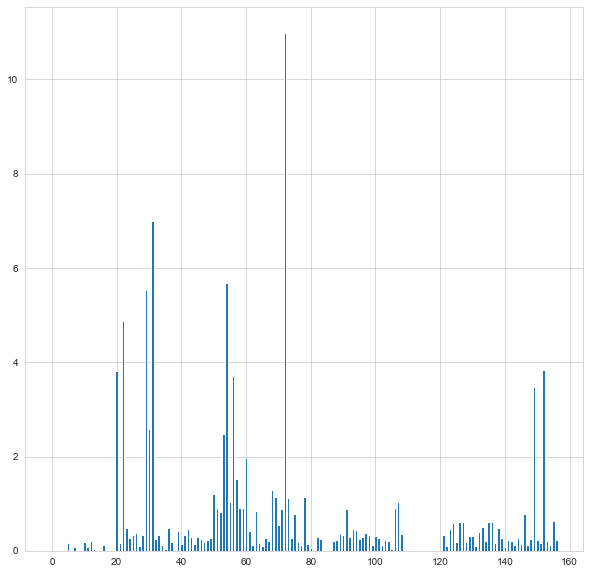

In [7]:
bold("**catboost特征重要性**")
print(cat_model.feature_importances_)
plt.rcParams['figure.figsize'] = (10,10)
print("feature num：", len(cat_model.feature_importances_))
plt.bar(range(len(cat_model.feature_importances_)), cat_model.feature_importances_)
feature_important = dict(zip(train_features, cat_model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print("*" * 100)
print(feature_important)

feature_import_usefull = [key for (key, value) in feature_important if value > 0.1]

print("*" * 100)
print("\n\n catboost 重要性 > 0.1 特征类别：", len(feature_import_usefull),  feature_import_usefull)